In [ ]:
# Remove this
#! pip install torch==2.3 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
! pip install --upgrade torch torchvision==0.15.0+cu118 --index-url https://download.pytorch.org/whl/cu118

#! pip install stacchip
#! pip install geopandas

! pip install contextily

In [1]:
import warnings

import geoarrow.pyarrow as ga
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pystac_client
import requests
import torch
import yaml
from box import Box

import stacchip.indexer
from stacchip.chipper import Chipper
from stacchip.indexer import Sentinel2Indexer
from torchvision.transforms import v2

import geopandas as gpd
import pandas as pd

from shapely.geometry import Polygon
import matplotlib.pyplot as plt

import math
import os
import random

import timm
import torch
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
from torch import nn
from torchvision.transforms import v2

from src.backbone import Transformer
from src.factory import DynamicEmbedding
from src.utils import posemb_sincos_2d_with_gsd

torch.set_float32_matmul_precision("medium")
os.environ["TORCH_CUDNN_V8_API_DISABLED"] = "1"

#from src.model import ClayMAEModule

import contextily as cx
import rasterio
from rasterio.plot import show

from shapely.geometry import box

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from shapely import wkb

import stackstac
import pystac_client
import numpy as np
import dask
from rasterio.enums import Resampling
from rasterstats import zonal_stats
import xarray as xr
import rioxarray as rxr

import torch.nn as nn

import shapely
from shapely.geometry import Polygon
from rasterio.features import rasterize
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim


from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

import seaborn as sns


warnings.filterwarnings("ignore")

### Load mining data and visualize

In [488]:
# Load mine polygons from Tang dataset and remove Z coordinate
mine_poly = gpd.read_file('data/mine_poly_shp').to_crs(epsg=4326)

def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    From : https://gist.github.com/rmania/8c88377a5c902dfbc134795a7af538d8
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
        else:
            print('no z')
    return new_geo

mine_poly.geometry = convert_3D_2D(mine_poly.geometry) 

print('Number of mine features:')
print(len(mine_poly))


Number of mine features:
74548


In [ ]:
# Load Aquarry QA'ed data
psql_bboxes = gpd.read_file('data/aquarry_psql_layer.csv')
psql_bboxes = gpd.GeoDataFrame(psql_bboxes,geometry = psql_bboxes['field_8'].apply(wkb.loads),crs='epsg:4326') # Convert WKB geometry
psql_bboxes['score'] = psql_bboxes['score'].apply(lambda score: float(score))


psql_bboxes.columns = ['cc', 'objectid', 'score', 'label', 'dataset', 'area', 'volume', 'wkb_geometry','field_9', 'category', 'field_11', 'geometry']

In [255]:
# Subset US QA data
US_QA = psql_bboxes[psql_bboxes['cc'] == 'US']
print(US_QA['category'].value_counts())

f"Number of confirmed mine features: {len(US_QA[US_QA['category']=='a'])}"

# Write to shapefile to inspect
#US_QA.to_file('data/US_QA')

category
\N    8512
a     1656
t      214
d      205
x      140
q       89
c       73
n       64
w       52
Name: count, dtype: int64


'Number of confirmed mine features: 1656'

In [85]:
US_QA_na = US_QA[~US_QA['category'].isin(['a','t','d','x','q','c','n','w'])]
print(f'Number of unlabeled features: {len(US_QA_na)}')

Number of unlabeled features: 8512


In [86]:
nm_im_districts = gpd.read_file('data/Districts_shapefiles/IM_districts.shp')
nm_coal_districts = gpd.read_file('data/Districts_shapefiles/Coal_fields.shp')
nm_metals_districts = gpd.read_file('data/Districts_shapefiles/Metals_districts.shp')
nm_potash_leaseareas = gpd.read_file('data/Districts_shapefiles/Potash_LeaseAreas.shp')
nm_U_districts = gpd.read_file('data/Districts_shapefiles/U_districts.shp')

#### Filter QA'ed dataset

In [87]:
states = gpd.read_file('data/state_boundaries')

# Get only QA'ed pits that are 0.5 or greater (i.e. have been QA'ed and/or higher likelihood)
print(f'Number of features in US dataset: {len(US_QA)}')
US_QA['score'] = US_QA['score'].apply(lambda score: float(score))
US_QA_filtered = US_QA[US_QA['score'] > 0.5]
US_QA_filtered['feature_idx'] = US_QA_filtered.reset_index(drop=True).index # Use for dissolve on spatial joining
print(f'Number of features in US with > 50% probability: {len(US_QA_filtered)}')


# Get only states with pit lakes
states['geometry'] = states['geometry'].apply(lambda geom: gpd.GeoSeries([geom]).unary_union)
states = gpd.GeoDataFrame(states, geometry='geometry', crs=states.crs).to_crs(epsg = 4326)
states = states[~states['STUSPS'].isin(['VI','PR','GU','MP','AS'])]

states_with_pits = gpd.sjoin(states, US_QA_filtered, how = 'left', predicate = 'intersects')
states_with_pits = states_with_pits[~states_with_pits['score'].isna()]

# Take out states with less than 5 pit lakes
states_with_enough_pits = states_with_pits['STUSPS'].value_counts() > 5
states_list = states_with_enough_pits[states_with_enough_pits].index.to_list()

states_with_low_pits = states_with_pits['STUSPS'].value_counts() < 5
print(f'States to remove: {states_with_low_pits[states_with_low_pits].index}')

states_filtered = states_with_pits[states_with_pits['STUSPS'].isin(states_list)].drop_duplicates('geometry')[['STUSPS','geometry']]

states_geometries = states[states['STUSPS'].isin(states_list)]
print(f'# of states being used: {len(states_geometries)}')

Number of features in US dataset: 11005
Number of features in US with > 50% probability: 2491
States to remove: Index(['NJ', 'NY', 'OR', 'KS'], dtype='object', name='STUSPS')
# of states being used: 36


#### Get pit lakes in each region

In [ ]:
#US_QA = US_QA.to_crs(epsg=8857)
US_QA_negative = US_QA[US_QA['category'].isin(['t', 'c', 'n', 'w', 'x','\\N'])]

# Perform a spatial join to find intersecting polygons
intersecting_groups = gpd.sjoin(US_QA_negative, US_QA_negative, how='left', predicate='intersects', lsuffix='left', rsuffix='right')

# Define a function to determine the merged category and max score for '\N'
def assign_category_and_score(group):
    categories = set(group['category_right'].dropna())  # Get unique intersecting categories
    max_score = group.loc[group['category_right'] == '\\N', 'score_right'].max()  # Get max score for '\N'

    # If any of ['t', 'c', 'n', 'w', 'x'] are present, set to 'other'
    if categories.intersection({'t', 'c', 'n', 'w', 'x'}):
        return pd.Series(['other', max_score])  
    elif categories == {'\\N'}:  # Only contains '\N'
        return pd.Series(['\\N', max_score])
    else:
        return pd.Series([group['category_left'].iloc[0], max_score])  # Keep original if no change needed

# Apply category and score assignment
intersecting_groups[['new_category', 'new_score']] = intersecting_groups.groupby(intersecting_groups.index).apply(assign_category_and_score)

def assign_category(group):
    categories = set(group.dropna())  # Get unique non-null categories

    # If 'other' is present, return 'other'
    if 'other' in categories:
        return 'other'
    elif categories == {'\\N'} or not categories:
        return '\\N'

    # Default case: if mixed but no valid category, return '\N'
    return '\\N'


def assign_max_score(group):
    return group.max()  # Take the maximum score for '\N'

# Dissolve with custom aggregation
merged_polygons = intersecting_groups.dissolve(
    by=intersecting_groups.index, 
    aggfunc={
        #'geometry': 'first',  # Keep one representative geometry
        'new_category': assign_category,  # Apply category logic
        'new_score': assign_max_score   # Max score for '\N'
    }
)

# Rename columns to match final output
merged_polygons.rename(columns={'category_right': 'new_category', 'score_right': 'score'}, inplace=True)

# Merge the intersecting polygons
#merged_polygons = intersecting_groups.dissolve(by=intersecting_groups.index, aggfunc='first')

# Assign updated categories and max score
#merged_polygons['category'] = intersecting_groups['new_category']
#merged_polygons['score'] = intersecting_groups['new_score']

# Convert back to original CRS
merged_polygons = merged_polygons.to_crs(epsg=4326)

In [349]:
US_QA_positive = US_QA[US_QA['category'].isin(['a', 'q', 'd'])]
US_QA_positive.rename(columns={'category': 'new_category', 'score': 'new_score'}, inplace = True)

In [353]:
US_QA_merged = pd.concat([US_QA_positive, merged_polygons])
US_QA_merged.rename(columns={'new_category': 'category', 'new_score': 'score'}, inplace = True)
len(US_QA_merged)

11005

In [354]:
US_QA_merged['category'].value_counts()

category
\N       7937
a        1656
other    1118
d         205
q          89
Name: count, dtype: int64

In [356]:
# US merged
# Get features in Minnesota

states = gpd.read_file('data/state_boundaries')
mn = states[states['STUSPS']=='MN']
mn = mn.to_crs(epsg = 4326).geometry.unary_union

mn_qa = US_QA_merged[US_QA_merged.geometry.intersects(mn)]
print(f'MN QAed mines: {(mn_qa['category'] == 'a').sum()}')


# Get features in IL, IN, KY, MS

states = gpd.read_file('data/state_boundaries')
il_in_ky_ms = states[states['STUSPS'].isin(['IL','IN','KY','MS'])]
print(il_in_ky_ms)
il_in_ky_ms = il_in_ky_ms.to_crs(epsg = 4326).geometry.unary_union 

il_in_ky_ms_qa = US_QA_merged[US_QA_merged.geometry.intersects(il_in_ky_ms)]
print(f'IL IN KY MS QAed mines: {(il_in_ky_ms_qa['category'] == 'a').sum()}')


# Get features in GA

states = gpd.read_file('data/state_boundaries')
ga = states[states['STUSPS']=='GA']
ga = ga.to_crs(epsg = 4326).geometry.unary_union

ga_qa = US_QA_merged[US_QA_merged.geometry.intersects(ga)]
print(f'GA QAed mines: {(ga_qa['category'] == 'a').sum()}')


# Getfeatures in TX

states = gpd.read_file('data/state_boundaries')
tx = states[states['STUSPS']=='TX']
tx = tx.to_crs(epsg = 4326).geometry.unary_union

tx_qa = US_QA_merged[US_QA_merged.geometry.intersects(tx)]
print(f'TX QAed mines: {(tx_qa['category'] == 'a').sum()}')


# Get features in AZ, NV

states = gpd.read_file('data/state_boundaries')
az_nv = states[states['STUSPS'].isin(['AZ','NV'])]
print(az_nv)
az_nv = az_nv.to_crs(epsg = 4326).geometry.unary_union 

az_nv_qa = US_QA_merged[US_QA_merged.geometry.intersects(az_nv)]
print(f'AZ, NV QAed mines: {(az_nv_qa['category'] == 'a').sum()}')


# Get features in MT, WY

states = gpd.read_file('data/state_boundaries')
mt_wy = states[states['STUSPS'].isin(['MT','WY'])]
print(mt_wy)
mt_wy = mt_wy.to_crs(epsg = 4326).geometry.unary_union 

mt_wy_qa = US_QA_merged[US_QA_merged.geometry.intersects(mt_wy)]
print(f'MT WY QAed mines: {(mt_wy_qa['category'] == 'a').sum()}')


MN QAed mines: 87
   STATEFP   STATENS      GEOIDFQ GEOID STUSPS         NAME LSAD  \
3       21  01779786  0400000US21    21     KY     Kentucky   00   
15      18  00448508  0400000US18    18     IN      Indiana   00   
20      17  01779784  0400000US17    17     IL     Illinois   00   
51      28  01779790  0400000US28    28     MS  Mississippi   00   

           ALAND      AWATER  \
3   102266598312  2384223544   
15   92786613552  1543998356   
20  143778366814  6216688589   
51  121533540877  3914738613   

                                             geometry  
3   MULTIPOLYGON (((-89.40565 36.52816, -89.39868 ...  
15  POLYGON ((-88.09776 37.90403, -88.09448 37.905...  
20  POLYGON ((-91.51297 40.18106, -91.51107 40.188...  
51  MULTIPOLYGON (((-88.50502 30.21574, -88.49164 ...  
IL IN KY MS QAed mines: 293
GA QAed mines: 275
TX QAed mines: 128
   STATEFP   STATENS      GEOIDFQ GEOID STUSPS     NAME LSAD         ALAND  \
19      32  01779793  0400000US32    32     NV   Nevada 

In [335]:
# Get features in Minnesota

states = gpd.read_file('data/state_boundaries')
mn = states[states['STUSPS']=='MN']
mn = mn.to_crs(epsg = 4326).geometry.unary_union

mn_qa = US_QA[US_QA.geometry.intersects(mn)]
print(f'MN QAed mines: {(mn_qa['category'] == 'a').sum()}')


# Get features in IL, IN, KY, MS

states = gpd.read_file('data/state_boundaries')
il_in_ky_ms = states[states['STUSPS'].isin(['IL','IN','KY','MS'])]
print(il_in_ky_ms)
il_in_ky_ms = il_in_ky_ms.to_crs(epsg = 4326).geometry.unary_union 

il_in_ky_ms_qa = US_QA[US_QA.geometry.intersects(il_in_ky_ms)]
print(f'IL IN KY MS QAed mines: {(il_in_ky_ms_qa['category'] == 'a').sum()}')


# Get features in GA

states = gpd.read_file('data/state_boundaries')
ga = states[states['STUSPS']=='GA']
ga = ga.to_crs(epsg = 4326).geometry.unary_union

ga_qa = US_QA[US_QA.geometry.intersects(ga)]
print(f'GA QAed mines: {(ga_qa['category'] == 'a').sum()}')


# Getfeatures in TX

states = gpd.read_file('data/state_boundaries')
tx = states[states['STUSPS']=='TX']
tx = tx.to_crs(epsg = 4326).geometry.unary_union

tx_qa = US_QA[US_QA.geometry.intersects(tx)]
print(f'TX QAed mines: {(tx_qa['category'] == 'a').sum()}')


# Get features in AZ, NV

states = gpd.read_file('data/state_boundaries')
az_nv = states[states['STUSPS'].isin(['AZ','NV'])]
print(az_nv)
az_nv = az_nv.to_crs(epsg = 4326).geometry.unary_union 

az_nv_qa = US_QA[US_QA.geometry.intersects(az_nv)]
print(f'AZ, NV QAed mines: {(az_nv_qa['category'] == 'a').sum()}')


# Get features in MT, WY

states = gpd.read_file('data/state_boundaries')
mt_wy = states[states['STUSPS'].isin(['MT','WY'])]
print(mt_wy)
mt_wy = mt_wy.to_crs(epsg = 4326).geometry.unary_union 

mt_wy_qa = US_QA[US_QA.geometry.intersects(mt_wy)]
print(f'MT WY QAed mines: {(mt_wy_qa['category'] == 'a').sum()}')


MN QAed mines: 87
   STATEFP   STATENS      GEOIDFQ GEOID STUSPS         NAME LSAD  \
3       21  01779786  0400000US21    21     KY     Kentucky   00   
15      18  00448508  0400000US18    18     IN      Indiana   00   
20      17  01779784  0400000US17    17     IL     Illinois   00   
51      28  01779790  0400000US28    28     MS  Mississippi   00   

           ALAND      AWATER  \
3   102266598312  2384223544   
15   92786613552  1543998356   
20  143778366814  6216688589   
51  121533540877  3914738613   

                                             geometry  
3   MULTIPOLYGON (((-89.40565 36.52816, -89.39868 ...  
15  POLYGON ((-88.09776 37.90403, -88.09448 37.905...  
20  POLYGON ((-91.51297 40.18106, -91.51107 40.188...  
51  MULTIPOLYGON (((-88.50502 30.21574, -88.49164 ...  
IL IN KY MS QAed mines: 293
GA QAed mines: 275
TX QAed mines: 128
   STATEFP   STATENS      GEOIDFQ GEOID STUSPS     NAME LSAD         ALAND  \
19      32  01779793  0400000US32    32     NV   Nevada 

In [336]:
# Data source: https://gisdata.mn.gov/dataset/water-dnr-hydrography

mn_water_features = gpd.read_file('data/dnr_hydro_features')
mn_water_features = mn_water_features[['wb_class','shape_Area','geometry']]
mine_classes = ['Natural Ore Mine','Mine Pit Lake','Mine Pit Lake (NF)','Tac/Natural Ore Mine']
pit_lake_mine_classes = ['Mine Pit Lake','Mine Pit Lake (NF)']

dnr_pit_lakes_nondry = mn_water_features.loc[mn_water_features['wb_class'].isin(pit_lake_mine_classes)].to_crs(epsg=4326)
dnr_pit_lakes = mn_water_features.loc[mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

dnr_water = mn_water_features[~mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

print(len(dnr_pit_lakes))
print(len(dnr_water))

200
130746


In [337]:
# Get pit lakes in NM

states = gpd.read_file('data/state_boundaries')
nm = states[states['STUSPS']=='NM']
nm = nm.to_crs(epsg = 4326).geometry.unary_union

nm_qa = US_QA[US_QA.geometry.intersects(nm)]
print(f'NM QAed mines: {(nm_qa['category'] == 'a').sum()}')
nm_qa_pits = nm_qa[nm_qa['category'].isin(['a', 'q','d'])] # QAed pit lakes 

#Not including Potash
nm_mining_districts = pd.concat([nm_im_districts, nm_coal_districts, nm_metals_districts, nm_U_districts])
nm_aggregated_pits = gpd.overlay(nm_qa_pits, nm_mining_districts, how="union")
print(len(nm_aggregated_pits))


NM QAed mines: 16
325


In [338]:
Canada_QA = psql_bboxes[psql_bboxes['cc'] == 'CA']
print(Canada_QA['category'].value_counts())

category
\N    3169
a      752
n      325
t       98
x       76
d       57
q       24
c       12
w        5
Name: count, dtype: int64


In [9]:
# Hold out Crosby MN

crosby_mn = gpd.read_file('data/crosby_mn.geojson')
dnr_pit_lakes = dnr_pit_lakes[~dnr_pit_lakes.geometry.intersects(crosby_mn.geometry.iloc[0])]
mn_qa = mn_qa[~mn_qa.geometry.intersects(crosby_mn.geometry.iloc[0])]
dnr_water = dnr_water[~dnr_water.geometry.intersects(crosby_mn.geometry.iloc[0])]

print((mn_qa['category']=='a').sum())
print(len(dnr_water))

87
129133


### Grab embeddings for mines and random embeddings

In [92]:
mn256 = gpd.read_parquet('data/north_mn_256_2022-06-01_2022-08-31_tile_embeddings_final_9288.parquet')
il_in_ky_ms256 = gpd.read_parquet("data/ms_il_in_ky_256_2022-06-01_2022-08-31_tile_embeddings_final_16297.parquet")
ga256 = gpd.read_parquet("data/ga_256_2022-06-01_2022-08-31_tile_embeddings_final_1933.parquet")
mt_wy256 = gpd.read_parquet("data/mt_wy_256_2022-06-01_2022-08-31_tile_embeddings_final_3985.parquet")
az_nv256 = gpd.read_parquet('data/nv_az_256_2022-06-01_2022-08-31_tile_embeddings_final_10312.parquet')
tx256 = gpd.read_parquet('data/tx_256_2022-06-01_2022-08-31_tile_embeddings_final_2661.parquet')

print(len(mn256))
print(mn256.columns)
print(mn256.crs)
print(len(il_in_ky_ms256))
print(il_in_ky_ms256.columns)
print(il_in_ky_ms256.crs)
print(len(ga256))
print(ga256.columns)
print(ga256.crs)
print(len(mt_wy256))
print(mt_wy256.columns)
print(mt_wy256.crs)
print(len(az_nv256))
print(az_nv256.columns)
print(az_nv256.crs)
print(len(tx256))
print(tx256.columns)
print(tx256.crs)

9288
Index(['minx', 'miny', 'maxx', 'maxy', 'embedding', 'geometry', 'centroid_x',
       'centroid_y', 'geometry_wkt'],
      dtype='object')
{"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "

### State by state

In [357]:
# Get Minnesota pit lakes from Aquarry and DNR
mn_qa_pits = mn_qa[mn_qa['category'].isin(['a','q','d'])] # QAed pit lakes 

mn_aggregated_pits = gpd.overlay(mn_qa_pits, dnr_pit_lakes, how="union")
mn_aggregated = gpd.overlay(mn_qa, dnr_pit_lakes, how="union")
mn_aggregated_nondry_pits =  gpd.overlay(mn_qa_pits, dnr_pit_lakes_nondry, how = 'union')

mn_qa_nonlakes = mn_qa[~mn_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 
mn_qa_nondrypits = mn_qa[mn_qa['category'].isin(['a'])]

# Get embeddings for lakes/water in MN
dnr_water = dnr_water.to_crs(epsg=4326)
# Reduce sample size
random_idx = random.sample(range(1, len(dnr_water)), 1000)
dnr_water_cropped = dnr_water.iloc[random_idx]


# Get AZ NV pit lakes from Aquarry

az_nv_qa_pits = az_nv_qa[az_nv_qa['category'].isin(['a','q','d'])] # QAed pit lakes
az_nv_qa_nonlakes = az_nv_qa[~az_nv_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 
az_nv_qa_nondrypits = az_nv_qa[az_nv_qa['category'].isin(['a'])]

# Get GA pit lakes from Aquarry

ga_qa_pits = ga_qa[ga_qa['category'].isin(['a','q','d'])] # QAed pit lakes
ga_qa_nonlakes = ga_qa[~ga_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 
ga_qa_nondrypits = ga_qa[ga_qa['category'].isin(['a'])]

# Get IL, IN, KY, MS pit lakes from Aquarry

il_in_ky_mo_qa_pits = il_in_ky_ms_qa[il_in_ky_ms_qa['category'].isin(['a','q','d'])] # QAed pit lakes
il_in_ky_mo_qa_nonlakes = il_in_ky_ms_qa[~il_in_ky_ms_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 
il_in_ky_mo_qa_nondrypits = il_in_ky_ms_qa[il_in_ky_ms_qa['category'].isin(['a'])]


# Get MT WY pit lakes from Aquarry

mt_wy_qa_pits = mt_wy_qa[mt_wy_qa['category'].isin(['a','q','d'])] # QAed pit lakes
mt_wy_qa_nonlakes = mt_wy_qa[~mt_wy_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 
mt_wy_qa_nondrypits = mt_wy_qa[mt_wy_qa['category'].isin(['a'])]

# Get TX pit lakes from Aquarry

tx_qa_pits = tx_qa[tx_qa['category'].isin(['a','q','d'])] # QAed pit lakes
tx_qa_nonlakes = tx_qa[~tx_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 
tx_qa_nondrypits = tx_qa[tx_qa['category'].isin(['a'])]

In [117]:
# Get Minnesota pit lakes from Aquarry and DNR
mn_qa_pits = mn_qa[mn_qa['category'].isin(['a','q'])] # QAed pit lakes 

mn_aggregated_pits = gpd.overlay(mn_qa_pits, dnr_pit_lakes, how="union")
mn_aggregated = gpd.overlay(mn_qa, dnr_pit_lakes, how="union")
mn_aggregated_nondry_pits =  gpd.overlay(mn_qa_pits, dnr_pit_lakes_nondry, how = 'union')

mn_qa_nonlakes = mn_qa[~mn_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get embeddings for lakes/water in MN
dnr_water = dnr_water.to_crs(epsg=4326)
# Reduce sample size
random_idx = random.sample(range(1, len(dnr_water)), 1000)
dnr_water_cropped = dnr_water.iloc[random_idx]

# Get IL, IN, KY, MS pit lakes from Aquarry

il_in_ky_ms_qa_pits = il_in_ky_ms_qa[il_in_ky_ms_qa['category'].isin(['a','q'])] # QAed pit lakes
il_in_ky_ms_qa_nonlakes = il_in_ky_ms_qa[~il_in_ky_ms_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get GA pit lakes from Aquarry

ga_qa_pits = ga_qa[ga_qa['category'].isin(['a','q'])] # QAed pit lakes
ga_qa_nonlakes = ga_qa[~ga_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get MT WY pit lakes from Aquarry

mt_wy_qa_pits = mt_wy_qa[mt_wy_qa['category'].isin(['a','q'])] # QAed pit lakes
mt_wy_qa_nonlakes = mt_wy_qa[~mt_wy_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get TX pit lakes from Aquarry

tx_qa_pits = tx_qa[tx_qa['category'].isin(['a','q'])] # QAed pit lakes
tx_qa_nonlakes = tx_qa[~tx_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get AZ NV pit lakes from Aquarry

az_nv_qa_pits = az_nv_qa[az_nv_qa['category'].isin(['a','q'])] # QAed pit lakes
az_nv_qa_nonlakes = az_nv_qa[~az_nv_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 


In [217]:
print(f'Number of unlabeled above 0.5 probability: {(US_QA.loc[US_QA['score'] > 0.5, 'category'] == '\\N').sum()}')
print(f'Previous modeling precision in US {(US_QA.loc[US_QA['score'] > 0.5, 'category'] == 'a').sum() / (US_QA['score'] > 0.5).sum()}')

Canada_QA_filtered = Canada_QA[Canada_QA['category'] != '\\N'] # remove unlabeled
print(f'Previous modeling precision in Canada: {(Canada_QA_filtered.loc[Canada_QA_filtered['score'].apply(float) > 0.5, 'category'] == 'a').sum() / (Canada_QA_filtered['score'].apply(float) > 0.5).sum()}')

Number of unlabeled above 0.5 probability: 0
Previous modeling precision in US 0.6647932557205941
Previous modeling precision in Canada: 0.5574499629355077


### Label embeddings with mine/no mine

In [525]:
# USE FOR MASON GENERATED EMBEDDINGS -- MERGED US
# Define function that marks each chip in intersecting and non-intersecting set of images as True if intersects chip embedding, False if not

def LabelEmbeddings1_5(positive_embeddings, polygons = gpd.GeoDataFrame()):
    """ Create GeoDataFrame that takes image files with intersection with polygon of interest and returns only positive chips and marks True and 
    takes images without intersection and mark all chips as False or returns only chips that intersect with polygons2
    
    Helpful if there may be false negatives within the image with intersecting polygons
    
    Parameters:
    positive_embeddings (GeoDataFrame): positive chip embeddings
    negative_embeddings (GeoDataFrame): negative chip embeddings

    Returns:
    data (GeoDataFrame): chips with positive and negative labels

    """
    #data = gpd.GeoDataFrame()

    data = gpd.sjoin(positive_embeddings, polygons, predicate='intersects',how = 'left',rsuffix="_1")
    data['mine'] = 0

    #data.loc[data['score'].isna(), 'score'] = 0
    #data.loc[data['score'].isna(), 'score'] = 

    #data['mine'] = 1 # Assign 1 to mine column for chips with embeddings

    #if polygons2.empty:
    #    for emb in negative_embeddings:
    #        negative_embeddings['mine'] = 0 # Assign 0 to mine column for chips without overlap
    #        data = pd.concat([data, negative_embeddings], ignore_index=True)
    #else:
    #    for emb in negative_embeddings:
     #       negative_chips = gpd.sjoin(negative_embeddings, polygons2, predicate='intersects',how = 'inner',rsuffix="_1")
      #      negative_chips = negative_chips[~negative_chips['index__1'].isna()] # Drop chips without intersection
       #     negative_chips['mine'] = 0
        #    data = pd.concat([data, negative_chips], ignore_index=True)

    # If chips have both pit lakes and lakes, they will appear multiple times in data. 
    # Mark chip as positive if it has at least one pit lake, and drop duplicates.
    #data['mine'] = data.groupby('geometry')['mine'].transform('max')  

    # Drop duplicates if you want to keep only one row per index
    #data = data.drop_duplicates(subset=['geometry'])

    # Get max of mine and score for each chip
    # SWAP OUT THESE LINES FOR NORMAL CLASSIFICATION
    data.loc[data['category'].isin(['a','q','d']), 'mine'] = 1

    # a = 3, q = 2, d = 1
    data['mine_feature'] = 0
    data.loc[data['category']=='a', 'mine_feature'] = float(3)
    data.loc[data['category']=='q', 'mine_feature'] = float(2)
    data.loc[data['category']=='d', 'mine_feature'] = float(1)
    data.loc[data['category'].isin(['t','x','c','n','w','other']), 'mine_feature'] = float(0.5)
    data['score'] = data['score'].apply(float)
    data['mine'] = data['mine'].apply(int)

    # Ensure score is 0 if not N/A or positive
    data.loc[data['category'] == 'other','score'] = 0
    data = data.groupby('geometry', as_index=False).agg({'mine': 'max','score': 'max','mine_feature':'max','category': list,'embedding':'first'})
    #data.loc[data['mine_feature']==0.5, 'category'] = 'other'    

    # Keep d and q as confirmed (a)
    #data.loc[data['mine'] == 1, 'category'] = 'a'

    print(f'Number of positive samples: {(data['mine'] == 1).sum()}') 

    datacrs = positive_embeddings.crs
    data = gpd.GeoDataFrame(data, geometry='geometry').set_crs(datacrs)

    data_flat = data.reset_index(drop = True)
    for idx in list(data_flat.index):
        data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    return data_flat

In [ ]:
# USE FOR MASON GENERATED EMBEDDINGS
# Define function that marks each chip in intersecting and non-intersecting set of images as True if intersects chip embedding, False if not

def LabelEmbeddings1_5(positive_embeddings, negative_embeddings, polygons = gpd.GeoDataFrame(), polygons2 = gpd.GeoDataFrame()):
    """ Create GeoDataFrame that takes image files with intersection with polygon of interest and returns only positive chips and marks True and 
    takes images without intersection and mark all chips as False or returns only chips that intersect with polygons2
    
    Helpful if there may be false negatives within the image with intersecting polygons
    
    Parameters:
    positive_embeddings (GeoDataFrame): positive chip embeddings
    negative_embeddings (GeoDataFrame): negative chip embeddings

    Returns:
    data (GeoDataFrame): chips with positive and negative labels

    """
    data = gpd.GeoDataFrame()

    positive_chips = gpd.sjoin(positive_embeddings, polygons, predicate='intersects',how = 'inner',rsuffix="_1")
    positive_chips = positive_chips[~positive_chips['index__1'].isna()] # Drop chips without intersection

    data = pd.concat([data, positive_chips], ignore_index=True)
    data['mine'] = 1 # Assign 1 to mine column for chips with embeddings

    if polygons2.empty:
        for emb in negative_embeddings:
            negative_embeddings['mine'] = 0 # Assign 0 to mine column for chips without overlap
            data = pd.concat([data, negative_embeddings], ignore_index=True)
    else:
        for emb in negative_embeddings:
            negative_chips = gpd.sjoin(negative_embeddings, polygons2, predicate='intersects',how = 'inner',rsuffix="_1")
            negative_chips = negative_chips[~negative_chips['index__1'].isna()] # Drop chips without intersection
            negative_chips['mine'] = 0
            data = pd.concat([data, negative_chips], ignore_index=True)

    # If chips have both pit lakes and lakes, they will appear multiple times in data. 
    # Mark chip as positive if it has at least one pit lake, and drop duplicates.
    #data['mine'] = data.groupby('geometry')['mine'].transform('max')  

    # Drop duplicates if you want to keep only one row per index
    #data = data.drop_duplicates(subset=['geometry'])

    # Get max of mine and score for each chip
    # SWAP OUT THESE LINES FOR NORMAL CLASSIFICATION
    data.loc[data['category'].isin(['\\N', 't','x','c','n','w']), 'mine'] = 0

    # a = 3, q = 2, d = 1
    data['mine_feature'] = 0
    data.loc[data['category']=='a', 'mine_feature'] = 3
    data.loc[data['category']=='q', 'mine_feature'] = 2
    data.loc[data['category']=='d', 'mine_feature'] = 1
    data.loc[data['category'].isin(['t','x','c','n','w']), 'mine_feature'] = 0.5

    data = data.groupby('geometry', as_index=False).agg({'mine': 'max','score': 'max','category': 'first','mine_feature': 'max','embedding':'first'})
    data.loc[data['mine_feature']==0.5, 'category'] = 'other'    

    # Keep d and q as confirmed (a)
    #data.loc[data['mine'] == 1, 'category'] = 'a'

    print(f'Number of positive samples: {(data['mine'] == 1).sum()}') 

    datacrs = positive_embeddings.crs
    data = gpd.GeoDataFrame(data, geometry='geometry').set_crs(datacrs)

    data_flat = data.reset_index(drop = True)
    for idx in list(data_flat.index):
        data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    return data_flat

In [95]:
# USE FOR MASON GENERATED EMBEDDINGS
# Define function that marks each chip in intersecting and non-intersecting set of images as True if intersects chip embedding, False if not

def LabelEmbeddings1_5_nm(embeddings, polygons):
    """ Create GeoDataFrame that takes image files with intersection with polygon of interest and returns only positive chips and marks True and 
    takes images without intersection and mark all chips as False or returns only chips that intersect with polygons2
    
    Helpful if there may be false negatives within the image with intersecting polygons
    
    Parameters:
    positive_embeddings (GeoDataFrame): positive chip embeddings
    negative_embeddings (GeoDataFrame): negative chip embeddings

    Returns:
    data (GeoDataFrame): chips with positive labels

    """
    data = gpd.sjoin(embeddings, polygons, predicate='intersects',how = 'left',rsuffix="_1")
    data['mine'] = 0 # Initialize column
    print(data)
    data.loc[~data['index__1'].isna(), 'mine'] = 1 # Assign 1 if intersects with pit lakes

    # If chips have both pit lakes and lakes, they will appear multiple times in data. 
    # Mark chip as positive if it has at least one pit lake, and drop duplicates.
    #data['mine'] = data.groupby('geometry')['mine'].transform('max')  

    # Drop duplicates if you want to keep only one row per index
    data = data.drop_duplicates(subset=['geometry'])

    # If chips have both pit lakes and lakes, they will appear multiple times in data. 
    # Mark chip as positive if it has at least one pit lake, and drop duplicates.
    #data['mine'] = data.groupby('geometry')['mine'].transform('max')  

    # Drop duplicates if you want to keep only one row per index
    #data = data.drop_duplicates(subset=['geometry'])

    # Get max of mine and score for each chip
    # SWAP OUT THESE LINES FOR NORMAL CLASSIFICATION
    # data.loc[data['category'].isin(['\\N', 't','x','c','n','w']), 'mine'] = 0

    # data = data.groupby('geometry', as_index=False).agg({'mine': 'max','score': 'max','category': 'first','embedding':'first'})

    # # Keep d and q as confirmed (a)
    # data.loc[data['mine'] == 1, 'category'] = 'a'

    print(f'Number of positive samples: {(data['mine'] == 1).sum()}') 

    datacrs = embeddings.crs
    data = gpd.GeoDataFrame(data, geometry='geometry').set_crs(datacrs)

    data_flat = data.reset_index(drop = True)
    for idx in list(data_flat.index):
        data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    return data_flat

#### Classification labeling

In [1781]:
# For labeling and including only confirmed pit lakes in particular
dataAZNV = LabelEmbeddings1_5(az_nv256, az_nv256, az_nv_qa_pits)
dataILINKYMS = LabelEmbeddings1_5(il_in_ky_ms256, il_in_ky_ms256, il_in_ky_ms_qa_pits)
dataGA = LabelEmbeddings1_5(ga256, ga256, ga_qa_pits)
dataMN = LabelEmbeddings1_5(mn256, mn256, mn_aggregated_pits)
dataMTWY = LabelEmbeddings1_5(mt_wy256, mt_wy256, mt_wy_qa_pits)
dataTX = LabelEmbeddings1_5(tx256, tx256, tx_qa_pits)

Number of positive samples: 101


KeyboardInterrupt: 

In [526]:
# MERGED
# Labeling and including all negatively marked or unconfirmed features
dataAZNV = LabelEmbeddings1_5(az_nv256, az_nv_qa)
dataILINKYMS = LabelEmbeddings1_5(il_in_ky_ms256, il_in_ky_ms_qa)
dataGA = LabelEmbeddings1_5(ga256, ga_qa)
dataMN = LabelEmbeddings1_5(mn256, mn_aggregated_pits)
dataMTWY = LabelEmbeddings1_5(mt_wy256, mt_wy_qa)
dataTX = LabelEmbeddings1_5(tx256, tx_qa)

Number of positive samples: 101
Number of positive samples: 216
Number of positive samples: 159
Number of positive samples: 107
Number of positive samples: 89
Number of positive samples: 66


In [ ]:
# Labeling and including all negatively marked or unconfirmed features
dataAZNV = LabelEmbeddings1_5(az_nv256, az_nv256, az_nv_qa)
dataILINKYMS = LabelEmbeddings1_5(il_in_ky_ms256, il_in_ky_ms256, il_in_ky_ms_qa)
dataGA = LabelEmbeddings1_5(ga256, ga256, ga_qa)
dataMN = LabelEmbeddings1_5(mn256, mn256, mn_aggregated_pits)
dataMTWY = LabelEmbeddings1_5(mt_wy256, mt_wy256, mt_wy_qa)
dataTX = LabelEmbeddings1_5(tx256, tx256, tx_qa)

Index(['minx', 'miny', 'maxx', 'maxy', 'embedding', 'geometry', 'centroid_x',
       'centroid_y', 'geometry_wkt', 'mine', 'index__1', 'cc', 'objectid',
       'score', 'label', 'dataset', 'area', 'volume', 'wkb_geometry',
       'field_9', 'category', 'field_11'],
      dtype='object')
Number of positive samples: 101
Index(['minx', 'miny', 'maxx', 'maxy', 'embedding', 'geometry', 'centroid_x',
       'centroid_y', 'geometry_wkt', 'mine', 'index__1', 'cc', 'objectid',
       'score', 'label', 'dataset', 'area', 'volume', 'wkb_geometry',
       'field_9', 'category', 'field_11'],
      dtype='object')
Number of positive samples: 216
Index(['minx', 'miny', 'maxx', 'maxy', 'embedding', 'geometry', 'centroid_x',
       'centroid_y', 'geometry_wkt', 'mine', 'index__1', 'cc', 'objectid',
       'score', 'label', 'dataset', 'area', 'volume', 'wkb_geometry',
       'field_9', 'category', 'field_11'],
      dtype='object')
Number of positive samples: 159
Index(['minx', 'miny', 'maxx', 'maxy', '

In [527]:
# Split pit lakes in AZ, NV
from shapely.ops import unary_union

states = gpd.read_file('data/state_boundaries')
az = states[states['STUSPS'] =='AZ']
nv = states[states['STUSPS'] == 'NV']
az = az.to_crs(epsg = 4326).geometry.unary_union 
nv = nv.to_crs(epsg = 4326).geometry.unary_union 

dataAZ = dataAZNV[dataAZNV.intersects(az)]
dataNV = dataAZNV[dataAZNV.intersects(nv)]
az_qa_pits = az_nv_qa_pits[az_nv_qa_pits.intersects(az)]
nv_qa_pits = az_nv_qa_pits[az_nv_qa_pits.intersects(nv)]
az_qa_nondrypits = az_nv_qa_nondrypits[az_nv_qa_nondrypits.intersects(az)]
nv_qa_nondrypits = az_nv_qa_nondrypits[az_nv_qa_nondrypits.intersects(nv)]

# Split pit lakes in IL IN KY MO
il = states[states['STUSPS'] =='IL'].to_crs(epsg = 4326).geometry.unary_union 
ind = states[states['STUSPS'] == 'IN'].to_crs(epsg = 4326).geometry.unary_union 
ky = states[states['STUSPS'] == 'KY'].to_crs(epsg = 4326).geometry.unary_union 
mo = states[states['STUSPS'] == 'MO'].to_crs(epsg = 4326).geometry.unary_union 

ilkymo = unary_union([il, ky, mo])

dataILKYMO = dataILINKYMS[dataILINKYMS.intersects(ilkymo)]
dataIN = dataILINKYMS[dataILINKYMS.intersects(ind)]
in_qa_pits = il_in_ky_mo_qa_pits[il_in_ky_mo_qa_pits.intersects(ind)]
il_ky_mo_qa_pits = il_in_ky_mo_qa_pits[il_in_ky_mo_qa_pits.intersects(ilkymo)]
in_qa_nondrypits = il_in_ky_mo_qa_nondrypits[il_in_ky_mo_qa_nondrypits.intersects(ind)]
il_ky_mo_qa_nondrypits = il_in_ky_mo_qa_nondrypits[il_in_ky_mo_qa_nondrypits.intersects(ilkymo)]


In [528]:
ont_256 = gpd.read_parquet('data/ontario_256_2024-09-01_2024-11-30_tile_embeddings_final_55477.parquet')
print(len(ont_256))
print(ont_256.columns)
print(ont_256.crs)
print(len(ont_256))
print(ont_256.columns)
print(ont_256.crs)

Canada_QA_pits = Canada_QA[Canada_QA['category'] == 'a']
dataONT = LabelEmbeddings1_5_nm(ont_256, Canada_QA_pits)

55477
Index(['minx', 'miny', 'maxx', 'maxy', 'embedding', 'geometry', 'centroid_x',
       'centroid_y', 'geometry_wkt'],
      dtype='object')
{"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": 

In [529]:
mn_full256 = gpd.read_parquet('data/mn_full_256_2024-09-01_2024-11-30_tile_embeddings_final_34351.parquet')
nm_256 = gpd.read_parquet('data/new_mexico_256_2024-09-01_2024-11-30_tile_embeddings_final_48009.parquet')

print(len(mn_full256))
print(mn_full256.columns)
print(mn_full256.crs)
print(len(nm_256))
print(nm_256.columns)
print(nm_256.crs)

nm_mining_districts = nm_mining_districts.to_crs(epsg = '4326')
#dataMN_full = LabelEmbeddings1_5(mn_full256, mn_full256, mn_aggregated_nondry_pits)
dataMN_full = LabelEmbeddings1_5(mn_full256, mn_aggregated_nondry_pits)
dataNM = LabelEmbeddings1_5_nm(nm_256, nm_aggregated_pits)

34351
Index(['minx', 'miny', 'maxx', 'maxy', 'embedding', 'geometry', 'centroid_x',
       'centroid_y', 'geometry_wkt'],
      dtype='object')
{"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": 

In [20]:
def ConcatenateEmbeddings(data):
    """ For each chip, appends embeddings from surrounding chips. 
    
    """
    data = data.reset_index(drop = True)
    touching_gdf  = gpd.sjoin(data, data, how = 'left', predicate = 'touches').dropna(subset=['index_right'])
    
    grouped_embeddings = touching_gdf.groupby('geometry')['embedding_right'].apply(list)

    for i in range(len(data)): 
        stacked = np.hstack(grouped_embeddings[i])
        data.at[i, 'embedding'] = np.hstack([data.loc[i, 'embedding'], stacked])

    # Function to horizontally stack embeddings
    def combine_embeddings(row):
        touching_embs = grouped_embeddings.get(row.name, [])  # Get touching embeddings

        if touching_embs:  
            return np.hstack([row['embedding']] + touching_embs)  # Stack original + touching
        else:
            return row['embedding']  # If no neighbors, keep original
    
    return data

In [21]:
# Get concatenated embeddings for additional context
dataAZNV = ConcatenateEmbeddings(dataAZNV)

dataGA = ConcatenateEmbeddings(dataGA)

dataILINKYMS = ConcatenateEmbeddings(dataILINKYMS)

dataMN = ConcatenateEmbeddings(dataMN)

dataMTWY = ConcatenateEmbeddings(dataMTWY)

dataTX = ConcatenateEmbeddings(dataTX)

KeyboardInterrupt: 

### NDWI Filtering

In [100]:
def CreateCSV(gdf, filename):
    file_name = f'file_path/{filename}.csv' # Adjust to correct file path

    gdf["geometry_wkb"] = gdf.geometry.apply(lambda geom: geom.wkb)

    # Save to CSV (excluding original geometry column)
    gdf = gdf.drop(columns=["geometry"])
    gdf.to_csv(file_name, index=False) # Don't keep index in CSV

    return

In [ ]:
# Create shapefiles
### NEED TO ADJUST IF DOING MORE THAN TANG

dataAZpositives_polys['preds'] = 0
dataAZpositives_polys.loc[dataAZpositives_polys['mine_prob'] > 0.5, 'preds'] = 1
dataAZexport = gpd.GeoDataFrame(dataAZpositives_polys.drop(columns = 'geometry'), geometry = 'exploded')
#dataAZexport.to_file('data/SEArizona_predictions.shp')
#CreateCSV(dataAZexport, 'SoutheastArizona_predictions.csv')

dataNVpositives_polys['preds'] = 0
dataNVpositives_polys.loc[dataNVpositives_polys['mine_prob'] > 0.5, 'preds'] = 1
dataNVexport = gpd.GeoDataFrame(dataNVpositives_polys.drop(columns = 'geometry'), geometry = 'exploded')
#dataNVexport.to_file('data/NNevada_predictions.shp')
#CreateCSV(dataNVexport, 'NorthernNevada_predictions.csv')

NameError: name 'dataAZpositives_polys' is not defined

In [885]:
# NV
#  Get positive prediction chips
dataNVpredicted = gpd.GeoDataFrame({'mine_prob': nv_predicted_outputs,'ground_truth': nv_ground_truths}, geometry = TangNVdata.reset_index(drop=True).geometry, crs = '4326')
dataNVpositives = dataNVpredicted[dataNVpredicted['mine_prob'] > 0.5]
dataNVpositives = dataNVpositives.to_crs(epsg = '8857') # Convert back to 8857 for easier chipping
print(f'Check if any geometries are NA: {dataNVpositives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
dataNVpositives_polys = NDWIFilter(dataNVpositives)

# Explode back into individual polygons
dataNVpositives_polys["exploded"] = dataNVpositives_polys['pit_lake_geoms'].apply(lambda x: x.geoms if type(x) == MultiPolygon else x)
dataNVpositives_polys = dataNVpositives_polys.explode("exploded", ignore_index=False)

Check if any geometries are NA: 0
Found 19 items
Reduced items to 5
Water mask positive pixels: 6472
Found 23 items
Reduced items to 5
Water mask positive pixels: 1786
Found 23 items
Reduced items to 5
Water mask positive pixels: 272
Found 23 items
Reduced items to 5
Water mask positive pixels: 6795
Found 23 items
Reduced items to 5
Water mask positive pixels: 2600
Found 23 items
Reduced items to 5
Water mask positive pixels: 34
Found 21 items
Reduced items to 5
Water mask positive pixels: 399
Found 19 items
Reduced items to 5
Water mask positive pixels: 4
Found 7 items
Reduced items to 5
Water mask positive pixels: 8
Found 17 items
Reduced items to 5
Water mask positive pixels: 30
Found 6 items
Reduced items to 5
Water mask positive pixels: 69
Found 6 items
Reduced items to 5
Water mask positive pixels: 2
Found 6 items
Reduced items to 5
Water mask positive pixels: 1
Found 9 items
Reduced items to 5
Water mask positive pixels: 38
Found 9 items
Reduced items to 5
Water mask positive pi

In [886]:
# dissolve into just unique chips
# Create updated prediction column
dataNVpredicted = dataNVpredicted.to_crs(epsg=8857) # Have to convert this one since there are slight differences
dataNVpositives_polys['updated_preds'] = dataNVpositives_polys['exploded'].apply(lambda x: 1 if x is not None else 0)
dataNVpositives_polys_chips = dataNVpositives_polys.drop_duplicates('geometry')

# Merge back in
dataNVpredicted_updated = dataNVpredicted.merge(dataNVpositives_polys_chips[['geometry', 'updated_preds']], on='geometry', how='left')
dataNVpredicted_updated.loc[dataNVpredicted_updated['updated_preds'].isna(), 'updated_preds'] = 0 

# Assign old values 
nv_updated_predictions = np.array(dataNVpredicted_updated['updated_preds'])

precision = precision_score(nv_ground_truths, nv_updated_predictions, average='binary')
recall = recall_score(nv_ground_truths, nv_updated_predictions, average='binary')
f1 = f1_score(nv_ground_truths, nv_updated_predictions, average='binary')
accuracy = accuracy_score(nv_ground_truths, nv_updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(nv_ground_truths)}')
print(f'True positives: {nv_ground_truths.sum()}')
print(f'Predicted positives: {nv_updated_predictions.sum()}')

Precision on test set: 0.1515
Recall on test set: 0.5000
Accuracy on test set: 0.7093
F1 score on test set: 0.2326
Total chips: 227
True positives: 20.0
Predicted positives: 66.0


In [932]:
# GA
#  Get positive prediction chips
dataGApredicted = gpd.GeoDataFrame({'mine_prob': ga_predicted_outputs,'ground_truth': ga_ground_truths}, geometry = TangGAdata.reset_index(drop=True).geometry, crs = '4326')
dataGApositives = dataGApredicted[dataGApredicted['mine_prob'] > 0.5]
dataGApositives = dataGApositives.to_crs(epsg = '8857') # Convert back to 8857 for easier chipping
print(f'Check if any geometries are NA: {dataGApositives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
dataGApositives_polys = NDWIFilter(dataGApositives)

# Explode back into individual polygons
dataGApositives_polys["exploded"] = dataGApositives_polys['pit_lake_geoms'].apply(lambda x: x.geoms if type(x) == MultiPolygon else x)
dataGApositives_polys = dataGApositives_polys.explode("exploded", ignore_index=False)

Check if any geometries are NA: 0
Found 3 items
Water mask positive pixels: 523
Found 2 items
Water mask positive pixels: 791
Found 3 items
Water mask positive pixels: 406
Found 3 items
Water mask positive pixels: 508
Found 3 items
Water mask positive pixels: 1917
Found 3 items
Water mask positive pixels: 1263
Found 3 items
Water mask positive pixels: 2913
Found 3 items
Water mask positive pixels: 1029
Found 3 items
Water mask positive pixels: 1427
Found 3 items
Water mask positive pixels: 3160
Found 3 items
Water mask positive pixels: 648
Found 3 items
Water mask positive pixels: 1671
Found 3 items
Water mask positive pixels: 1177
Found 3 items
Water mask positive pixels: 539
Found 3 items
Water mask positive pixels: 590
Found 3 items
Water mask positive pixels: 1330
Found 3 items
Water mask positive pixels: 1145
Found 3 items
Water mask positive pixels: 1105
Found 3 items
Water mask positive pixels: 973
Found 3 items
Water mask positive pixels: 1928
Found 3 items
Water mask positive 

In [933]:
# dissolve into just unique chips
# Create updated prediction column
dataGApredicted = dataGApredicted.to_crs(epsg=8857) # Have to convert this one since there are slight differences
dataGApositives_polys['updated_preds'] = dataGApositives_polys['exploded'].apply(lambda x: 1 if x is not None else 0)
dataGApositives_polys_chips = dataGApositives_polys.drop_duplicates('geometry')

# Merge back in
dataGApredicted_updated = dataGApredicted.merge(dataGApositives_polys_chips[['geometry', 'updated_preds']], on='geometry', how='left')
dataGApredicted_updated.loc[dataGApredicted_updated['updated_preds'].isna(), 'updated_preds'] = 0 

# Assign old values 
ga_updated_predictions = np.array(dataGApredicted_updated['updated_preds'])

precision = precision_score(ga_ground_truths, ga_updated_predictions, average='binary')
recall = recall_score(ga_ground_truths, ga_updated_predictions, average='binary')
f1 = f1_score(ga_ground_truths, ga_updated_predictions, average='binary')
accuracy = accuracy_score(ga_ground_truths, ga_updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(ga_ground_truths)}')
print(f'True positives: {ga_ground_truths.sum()}')
print(f'Predicted positives: {ga_updated_predictions.sum()}')

Precision on test set: 0.8143
Recall on test set: 0.7862
Accuracy on test set: 0.7311
F1 score on test set: 0.8000
Total chips: 212
True positives: 145.0
Predicted positives: 140.0


In [934]:
dataGApositives_polys['preds'] = 0
dataGApositives_polys.loc[dataGApositives_polys['mine_prob'] > 0.5, 'preds'] = 1
dataGAexport = gpd.GeoDataFrame(dataGApositives_polys.drop(columns = 'geometry'), geometry = 'exploded')
dataGAexport.to_file('data/CentralGeorgia_predictions.shp')
#CreateCSV(dataNVexport, 'NorthernNevada_predictions.csv')

In [949]:
# IN
#  Get positive prediction chips
dataINpredicted = gpd.GeoDataFrame({'mine_prob': in_predicted_outputs,'ground_truth': in_ground_truths}, 
                                    geometry = TangINdata.reset_index(drop=True).geometry, crs = '4326')
dataINpositives = dataINpredicted[dataINpredicted['mine_prob'] > 0.5]
dataINpositives = dataINpositives.to_crs(epsg = '8857') # Convert back to 8857 for easier chipping
print(f'Check if any geometries are NA: {dataINpositives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
dataINpositives_polys = NDWIFilter(dataINpositives)

# Explode back into individual polygons
dataINpositives_polys["exploded"] = dataINpositives_polys['pit_lake_geoms'].apply(lambda x: x.geoms if type(x) == MultiPolygon else x)
dataINpositives_polys = dataINpositives_polys.explode("exploded", ignore_index=False)

# dissolve into just unique chips
# Create updated prediction column
dataINpredicted = dataINpredicted.to_crs(epsg=8857) # Have to convert this one since there are slight differences
dataINpositives_polys['updated_preds'] = dataINpositives_polys['exploded'].apply(lambda x: 1 if x is not None else 0)
dataINpositives_polys_chips = dataINpositives_polys.drop_duplicates('geometry')

# Merge back in
dataINpredicted_updated = dataINpredicted.merge(dataINpositives_polys_chips[['geometry', 'updated_preds']], on='geometry', how='left')
dataINpredicted_updated.loc[dataINpredicted_updated['updated_preds'].isna(), 'updated_preds'] = 0 

# Assign old values 
in_updated_predictions = np.array(dataINpredicted_updated['updated_preds'])

precision = precision_score(in_ground_truths, in_updated_predictions, average='binary')
recall = recall_score(in_ground_truths, in_updated_predictions, average='binary')
f1 = f1_score(in_ground_truths, in_updated_predictions, average='binary')
accuracy = accuracy_score(in_ground_truths, in_updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(in_ground_truths)}')
print(f'True positives: {in_ground_truths.sum()}')
print(f'Predicted positives: {in_updated_predictions.sum()}')

Check if any geometries are NA: 0
Found 12 items
Reduced items to 5
Water mask positive pixels: 2232
Found 12 items
Reduced items to 5
Water mask positive pixels: 651
Found 12 items
Reduced items to 5
Water mask positive pixels: 2100
Found 13 items
Reduced items to 5
Water mask positive pixels: 93
Found 8 items
Reduced items to 5
Water mask positive pixels: 552
Found 8 items
Reduced items to 5
Water mask positive pixels: 520
Found 8 items
Reduced items to 5
Water mask positive pixels: 1158
Found 8 items
Reduced items to 5
Water mask positive pixels: 1737
Found 8 items
Reduced items to 5
Water mask positive pixels: 3032
Found 8 items
Reduced items to 5
Water mask positive pixels: 2283
Found 8 items
Reduced items to 5
Water mask positive pixels: 4134
Found 8 items
Reduced items to 5
Water mask positive pixels: 929
Found 12 items
Reduced items to 5
Water mask positive pixels: 2211
Found 4 items
Water mask positive pixels: 4053
Found 6 items
Reduced items to 5
Water mask positive pixels: 5

In [950]:
dataINpositives_polys['preds'] = 0
dataINpositives_polys.loc[dataINpositives_polys['mine_prob'] > 0.5, 'preds'] = 1
dataINexport = gpd.GeoDataFrame(dataINpositives_polys.drop(columns = 'geometry'), geometry = 'exploded')
dataINexport.to_file('data/SWIndiana_predictions.shp')
#CreateCSV(dataNVexport, 'NorthernNevada_predictions.csv')

In [967]:
# IL KY MO
#  Get positive prediction chips
dataILKYMOpredicted = gpd.GeoDataFrame({'mine_prob': ilkymo_predicted_outputs,'ground_truth': ilkymo_ground_truths}, 
                                    geometry = TangILKYMOdata.reset_index(drop=True).geometry, crs = '4326')
dataILKYMOpositives = dataILKYMOpredicted[dataILKYMOpredicted['mine_prob'] > 0.5]
dataILKYMOpositives = dataILKYMOpositives.to_crs(epsg = '8857') # Convert back to 8857 for easier chipping
print(f'Check if any geometries are NA: {dataILKYMOpositives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
dataILKYMOpositives_polys = NDWIFilter(dataILKYMOpositives)

# Explode back into individual polygons
dataILKYMOpositives_polys["exploded"] = dataILKYMOpositives_polys['pit_lake_geoms'].apply(lambda x: x.geoms if type(x) == MultiPolygon else x)
dataILKYMOpositives_polys = dataILKYMOpositives_polys.explode("exploded", ignore_index=False)


Check if any geometries are NA: 0
Found 7 items
Reduced items to 5
Water mask positive pixels: 6166
Found 9 items
Reduced items to 5
Water mask positive pixels: 1368
Found 9 items
Reduced items to 5
Water mask positive pixels: 1847
Found 9 items
Reduced items to 5
Water mask positive pixels: 2286
Found 15 items
Reduced items to 5
Water mask positive pixels: 351
Found 15 items
Reduced items to 5
Water mask positive pixels: 463
Found 9 items
Reduced items to 5
Water mask positive pixels: 1590
Found 9 items
Reduced items to 5
Water mask positive pixels: 685
Found 15 items
Reduced items to 5
Water mask positive pixels: 1424
Found 9 items
Reduced items to 5
Water mask positive pixels: 1081
Found 9 items
Reduced items to 5
Water mask positive pixels: 1471
Found 9 items
Reduced items to 5
Water mask positive pixels: 1883
Found 9 items
Reduced items to 5
Water mask positive pixels: 3448
Found 5 items
Water mask positive pixels: 670
Found 5 items
Water mask positive pixels: 2357
Found 5 items
W

NameError: name 'dataILKYMOpositives_polys_chips' is not defined

In [968]:

# dissolve into just unique chips
# Create updated prediction column
dataILKYMOpredicted = dataILKYMOpredicted.to_crs(epsg=8857) # Have to convert this one since there are slight differences
dataILKYMOpositives_polys['updated_preds'] = dataILKYMOpositives_polys['exploded'].apply(lambda x: 1 if x is not None else 0)
dataILKYMOpositives_polys_chips = dataILKYMOpositives_polys.drop_duplicates('geometry')

# Merge back in
dataILKYMOpredicted_updated = dataILKYMOpredicted.merge(dataILKYMOpositives_polys_chips[['geometry', 'updated_preds']], on='geometry', how='left')
dataILKYMOpredicted_updated.loc[dataILKYMOpredicted_updated['updated_preds'].isna(), 'updated_preds'] = 0 

# Assign old values 
ilkymo_updated_predictions = np.array(dataILKYMOpredicted_updated['updated_preds'])

precision = precision_score(ilkymo_ground_truths, ilkymo_updated_predictions, average='binary')
recall = recall_score(ilkymo_ground_truths, ilkymo_updated_predictions, average='binary')
f1 = f1_score(ilkymo_ground_truths, ilkymo_updated_predictions, average='binary')
accuracy = accuracy_score(ilkymo_ground_truths, ilkymo_updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(ilkymo_ground_truths)}')
print(f'True positives: {ilkymo_ground_truths.sum()}')
print(f'Predicted positives: {ilkymo_updated_predictions.sum()}')

Precision on test set: 0.4333
Recall on test set: 0.4952
Accuracy on test set: 0.6195
F1 score on test set: 0.4622
Total chips: 318
True positives: 105.0
Predicted positives: 120.0


In [969]:
dataILKYMOpositives_polys['preds'] = 0
dataILKYMOpositives_polys.loc[dataILKYMOpositives_polys['mine_prob'] > 0.5, 'preds'] = 1
dataILKYMOexport = gpd.GeoDataFrame(dataILKYMOpositives_polys.drop(columns = 'geometry'), geometry = 'exploded', crs = '8857')
dataILKYMOexport.to_file('data/IllinoisKentuckyMissouri_predictions.shp')
#CreateCSV(dataNVexport, 'NorthernNevada_predictions.csv')

In [982]:
# MN
#  Get positive prediction chips
dataMNpredicted = gpd.GeoDataFrame({'mine_prob': mn_predicted_outputs,'ground_truth': mn_ground_truths}, 
                                    geometry = TangMNdata.reset_index(drop=True).geometry, crs = '4326')
dataMNpositives = dataMNpredicted[dataMNpredicted['mine_prob'] > 0.5]
dataMNpositives = dataMNpositives.to_crs(epsg = '8857') # Convert back to 8857 for easier chipping
print(f'Check if any geometries are NA: {dataMNpositives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
dataMNpositives_polys = NDWIFilter(dataMNpositives)

# Explode back into individual polygons
dataMNpositives_polys["exploded"] = dataMNpositives_polys['pit_lake_geoms'].apply(lambda x: x.geoms if type(x) == MultiPolygon else x)
dataMNpositives_polys = dataMNpositives_polys.explode("exploded", ignore_index=False)

# dissolve into just unique chips
# Create updated prediction column
dataMNpredicted = dataMNpredicted.to_crs(epsg=8857) # Have to convert this one since there are slight differences
dataMNpositives_polys['updated_preds'] = dataMNpositives_polys['exploded'].apply(lambda x: 1 if x is not None else 0)
dataMNpositives_polys_chips = dataMNpositives_polys.drop_duplicates('geometry')

# Merge back in
dataMNpredicted_updated = dataMNpredicted.merge(dataMNpositives_polys_chips[['geometry', 'updated_preds']], on='geometry', how='left')
dataMNpredicted_updated.loc[dataMNpredicted_updated['updated_preds'].isna(), 'updated_preds'] = 0 

# Assign old values 
mn_updated_predictions = np.array(dataMNpredicted_updated['updated_preds'])

precision = precision_score(mn_ground_truths, mn_updated_predictions, average='binary')
recall = recall_score(mn_ground_truths, mn_updated_predictions, average='binary')
f1 = f1_score(mn_ground_truths, mn_updated_predictions, average='binary')
accuracy = accuracy_score(mn_ground_truths, mn_updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(mn_ground_truths)}')
print(f'True positives: {mn_ground_truths.sum()}')
print(f'Predicted positives: {mn_updated_predictions.sum()}')

Check if any geometries are NA: 0
Found 3 items
Water mask positive pixels: 8241
Found 3 items
Water mask positive pixels: 6298
Found 3 items
Water mask positive pixels: 3408
Found 3 items
Water mask positive pixels: 1071
Found 3 items
Water mask positive pixels: 2864
Found 3 items
Water mask positive pixels: 4508
Found 3 items
Water mask positive pixels: 280
Found 3 items
Water mask positive pixels: 594
Found 3 items
Water mask positive pixels: 2231
Found 3 items
Water mask positive pixels: 262
Found 3 items
Water mask positive pixels: 14401
Found 3 items
Water mask positive pixels: 1977
Found 3 items
Water mask positive pixels: 1348
Found 3 items
Water mask positive pixels: 1860
Found 3 items
Water mask positive pixels: 430
Found 3 items
Water mask positive pixels: 95
Found 3 items
Water mask positive pixels: 5570
Found 3 items
Water mask positive pixels: 4391
Found 3 items
Water mask positive pixels: 5898
Found 3 items
Water mask positive pixels: 2557
Found 3 items
Water mask positi

In [983]:
dataMNpositives_polys['preds'] = 0
dataMNpositives_polys.loc[dataMNpositives_polys['mine_prob'] > 0.5, 'preds'] = 1
dataMNexport = gpd.GeoDataFrame(dataMNpositives_polys.drop(columns = 'geometry'), geometry = 'exploded', crs = '8857')
dataMNexport.to_file('data/NEMinnesota_predictions.shp')
#CreateCSV(dataNVexport, 'NorthernNevada_predictions.csv')

In [43]:
# MT WY
#  Get positive prediction chips
dataMTWYpredicted = gpd.GeoDataFrame({'mine_prob': mtwy_predicted_outputs,'ground_truth': mtwy_ground_truths}, 
                                    geometry = TangMTWYdata.reset_index(drop=True).geometry, crs = '4326')
dataMTWYpositives = dataMTWYpredicted[dataMTWYpredicted['mine_prob'] > 0.5]
dataMTWYpositives = dataMTWYpositives.to_crs(epsg = '8857') # Convert back to 8857 for easier chipping
print(f'Check if any geometries are NA: {dataMTWYpositives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
dataMTWYpositives_polys = NDWIFilter(dataMTWYpositives)

# Explode back into individual polygons
dataMTWYpositives_polys["exploded"] = dataMTWYpositives_polys['pit_lake_geoms'].apply(lambda x: x.geoms if type(x) == MultiPolygon else x)
dataMTWYpositives_polys = dataMTWYpositives_polys.explode("exploded", ignore_index=False)

# dissolve into just unique chips
# Create updated prediction column
dataMTWYpredicted = dataMTWYpredicted.to_crs(epsg=8857) # Have to convert this one since there are slight differences
dataMTWYpositives_polys['updated_preds'] = dataMTWYpositives_polys['exploded'].apply(lambda x: 1 if x is not None else 0)
dataMTWYpositives_polys_chips = dataMTWYpositives_polys.drop_duplicates('geometry')

# Merge back in
dataMTWYpredicted_updated = dataMTWYpredicted.merge(dataMTWYpositives_polys_chips[['geometry', 'updated_preds']], on='geometry', how='left')
dataMTWYpredicted_updated.loc[dataMTWYpredicted_updated['updated_preds'].isna(), 'updated_preds'] = 0 

# Assign old values 
mtwy_updated_predictions = np.array(dataMTWYpredicted_updated['updated_preds'])

precision = precision_score(mtwy_ground_truths, mtwy_updated_predictions, average='binary')
recall = recall_score(mtwy_ground_truths, mtwy_updated_predictions, average='binary')
f1 = f1_score(mtwy_ground_truths, mtwy_updated_predictions, average='binary')
accuracy = accuracy_score(mtwy_ground_truths, mtwy_updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(mtwy_ground_truths)}')
print(f'True positives: {mtwy_ground_truths.sum()}')
print(f'Predicted positives: {mtwy_updated_predictions.sum()}')

dataMTWYpositives_polys['preds'] = 0
dataMTWYpositives_polys.loc[dataMTWYpositives_polys['mine_prob'] > 0.5, 'preds'] = 1
dataMTWYexport = gpd.GeoDataFrame(dataMTWYpositives_polys.drop(columns = 'geometry'), geometry = 'exploded', crs = '8857')
dataMTWYexport.to_file('data/MontanaWyoming_predictions.shp')
#CreateCSV(dataNVexport, 'NorthernNevada_predictions.csv')

Check if any geometries are NA: 0
Found 6 items
Reduced items to 5
Water mask positive pixels: 630
Found 6 items
Reduced items to 5
Water mask positive pixels: 3294
Found 11 items
Reduced items to 5
Water mask positive pixels: 13
Found 11 items
Reduced items to 5
Water mask positive pixels: 568
Found 11 items
Reduced items to 5
Water mask positive pixels: 2181
Found 11 items
Reduced items to 5
Water mask positive pixels: 10030
Found 11 items
Reduced items to 5
Water mask positive pixels: 607
Found 11 items
Reduced items to 5
Water mask positive pixels: 730
Found 23 items
Reduced items to 5
Water mask positive pixels: 0
Found 23 items
Reduced items to 5
Water mask positive pixels: 961
Found 15 items
Reduced items to 5
Water mask positive pixels: 203
Found 9 items
Reduced items to 5
Water mask positive pixels: 296
Found 9 items
Reduced items to 5
Water mask positive pixels: 84
Found 9 items
Reduced items to 5
Water mask positive pixels: 141
Found 9 items
Reduced items to 5
Water mask pos

In [105]:
# Ontario
#  Get positive prediction chips
dataONTpredicted = gpd.GeoDataFrame({'mine_prob': ont_predicted_outputs,'ground_truth': ont_ground_truths}, 
                                    geometry = dataONTmarked.reset_index(drop=True).geometry, crs = '4326')
dataONTpositives = dataONTpredicted[dataONTpredicted['mine_prob'] > 0.5]
dataONTpositives = dataONTpositives.to_crs(epsg = '8857') # Convert back to 8857 for easier chipping
print(f'Check if any geometries are NA: {dataONTpositives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
dataONTpositives_polys = NDWIFilter(dataONTpositives)

# Explode back into individual polygons
dataONTpositives_polys["exploded"] = dataONTpositives_polys['pit_lake_geoms'].apply(lambda x: x.geoms if type(x) == MultiPolygon else x)
dataONTpositives_polys = dataONTpositives_polys.explode("exploded", ignore_index=False)


Check if any geometries are NA: 0
Found 3 items
Water mask positive pixels: 502
Found 3 items
Water mask positive pixels: 38
Found 3 items
Water mask positive pixels: 6184
Found 3 items
Water mask positive pixels: 994
Found 3 items
Water mask positive pixels: 2935
Found 2 items
Water mask positive pixels: 43
Found 2 items
Water mask positive pixels: 1334
Found 2 items
Water mask positive pixels: 5720
Found 2 items
Water mask positive pixels: 54
Found 4 items
Water mask positive pixels: 78
Found 2 items
Water mask positive pixels: 195
Found 2 items
Water mask positive pixels: 3628
Found 4 items
Water mask positive pixels: 3023
Found 4 items
Water mask positive pixels: 4023
Found 4 items
Water mask positive pixels: 664
Found 4 items
Water mask positive pixels: 1369
Found 4 items
Water mask positive pixels: 9453
Found 4 items
Water mask positive pixels: 370
Found 4 items
Water mask positive pixels: 4509
Found 4 items
Water mask positive pixels: 338
Found 4 items
Water mask positive pixels

In [135]:

# dissolve into just unique chips
# Create updated prediction column
dataONTpredicted = dataONTpredicted.to_crs(epsg=8857) # Have to convert this one since there are slight differences
dataONTpositives_polys['updated_preds'] = dataONTpositives_polys['exploded'].apply(lambda x: 1 if x is not None else 0)
dataONTpositives_polys_chips = dataONTpositives_polys.drop_duplicates('geometry')
dataONTpositives_polys_chips['mine'] =  dataONTpositives_polys_chips['mine_prob'].apply(lambda x: 1 if x > 0.5 else 0)
#dataONTpositives_polys_chips.loc[dataONTpositives_polys_chips['pit_lake_polygons'].isna(), 'updated_preds'] = dataONTpositives_polys_chips.loc[dataONTpositives_polys_chips['pit_lake_polygons'].isna(), 'mine'] 

# Merge back in
dataONTpredicted_updated = dataONTpredicted.merge(dataONTpositives_polys_chips[['geometry', 'updated_preds']], on='geometry', how='left')
dataONTpredicted_updated.loc[dataONTpredicted_updated['updated_preds'].isna(), 'updated_preds'] = 0

# Assign old values 
ont_updated_predictions = np.array(dataONTpredicted_updated['updated_preds'])

precision = precision_score(ont_ground_truths, ont_updated_predictions, average='binary')
recall = recall_score(ont_ground_truths, ont_updated_predictions, average='binary')
f1 = f1_score(ont_ground_truths, ont_updated_predictions, average='binary')
accuracy = accuracy_score(ont_ground_truths, ont_updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(ont_ground_truths)}')
print(f'True positives: {ont_ground_truths.sum()}')
print(f'Predicted positives: {ont_updated_predictions.sum()}')

#dataONTpositives_polys['preds'] = 0
#dataONTpositives_polys.loc[dataONTpositives_polys['mine_prob'] > 0.5, 'preds'] = 1
#dataONTexport = gpd.GeoDataFrame(dataONTpositives_polys.drop(columns = 'geometry'), geometry = 'exploded', crs = '8857')
#dataONTexport.to_file('data/Ontario_predictions.shp')
#CreateCSV(dataNVexport, 'NorthernNevada_predictions.csv')

Precision on test set: 0.0183
Recall on test set: 0.5196
Accuracy on test set: 0.9478
F1 score on test set: 0.0353
Total chips: 55477
True positives: 102.0
Predicted positives: 2902.0


In [53]:
dataONTpredicted = gpd.GeoDataFrame({'mine_prob': ont_predicted_outputs,'ground_truth': ont_ground_truths}, 
                                    geometry = dataONTmarked.reset_index(drop=True).geometry, crs = '4326')
dataONTnegatives = dataONTpredicted[dataONTpredicted['mine_prob'] < 0.2]
dataONTnegatives = dataONTnegatives.to_crs(epsg = '8857') # Convert back to 8857 for easier chipping
print(f'Check if any geometries are NA: {dataONTnegatives.geometry.isna().sum()}')


Check if any geometries are NA: 0


In [ ]:
dataONTnegatives.to_parquet('data/Ontario_lowpredictions.parquet')

In [144]:
ONTexport = dataONTpositives_polys_chips.drop(columns = ['pit_lake_polygons','pit_lake_geoms','exploded'])
ONTexport = ONTexport[ONTexport['updated_preds'] == 1].reset_index(drop = True).to_crs(epsg = '4326')

# Positive predictions only
ONTexport.to_parquet('data/Ontario_predictions.parquet')

In [ ]:
ONTexport_filtered_pos = ONTexport[ONTexport['mine_prob'] > 0.8]
ONTexport_filtered_neg = ONTexport[ONTexport['mine_prob'] < 0.2]
ONTexport_filtered_mid = ONTexport[(ONTexport['mine_prob'] < 0.6) & (ONTexport['mine_prob'] > 0.4)]

ONTexport_filtered_pos.to_parquet('data/Ontario_highpredictions.parquet')
ONTexport_filtered_neg.to_parquet('data/Ontario_lowpredictions.parquet')
ONTexport_filtered_mid.to_parquet('data/Ontario_midpredictions.parquet')

In [62]:
ONTexport_filtered_neg = gpd.read_parquet('data/Ontario_lowpredictions.parquet')
ONTexport_filtered_mid = gpd.read_parquet('data/Ontario_midpredictions.parquet')
ONTexport_filtered_pos = gpd.read_parquet('data/Ontario_highpredictions.parquet')

In [75]:
randomidx = [random.randint(0, 99) for _ in range(100)]
ONTexport_filtered_neg = dataONTnegatives.iloc[randomidx].to_crs(epsg = 4326)

ONTexport_filtered_pos = ONTexport[ONTexport['mine_prob'] > 0.8].iloc[randomidx]
ONTexport_filtered_mid = ONTexport[(ONTexport['mine_prob'] < 0.6) & (ONTexport['mine_prob'] > 0.4)].iloc[randomidx]

ONTpos_neg_mid = pd.concat([ONTexport_filtered_pos,ONTexport_filtered_neg,ONTexport_filtered_mid]).reset_index(drop=True)
ONTpos_neg_mid['index'] = ONTpos_neg_mid.index

In [76]:
ONTpos_neg_mid_centroid = ONTpos_neg_mid['geometry'].centroid
ONTpos_neg_mid_centroid.to_csv('data/centroids')

ONTpos_neg_mid.to_parquet('data/ontario_pos_neg_mid.parquet')

In [81]:
ONTpos_neg_mid_prob = ONTpos_neg_mid['mine_prob']
ONTpos_neg_mid_prob.to_csv('data/probs')

### Build classification model to predict presence of pit lakes

In [537]:
# Mark positive samples 
import math

def MarkSamples(data, polygons, pct):
    """ Mark as positive if intersection is greater than given % of area.
    """
    # Get polygon of intersection for each chip
    positive_data = data[data['mine'] == 1]
    negative_data = data[data['mine'] == 0]
    positive_data['emb_idx'] = positive_data.index
    intersecting = gpd.overlay(positive_data, polygons, how = 'intersection') # Returns polygons of intersection
    intersecting = intersecting.dissolve(by='emb_idx') # Makes intersecting index match with data, adds areas of intersection
    intersecting['overlapping_area'] = intersecting.geometry.area

    # Merge into one dataframe 
    positive_data = positive_data.merge(intersecting['overlapping_area'], left_index = True, right_index = True, how='left')

    # Check intersection % and mark True/False
    for index, row in positive_data.iterrows():
        pct_overlap = row['overlapping_area'] / row.geometry.area
        positive_data.loc[index,'pct_pitlake'] = pct_overlap
        if pct_overlap >= pct:
            positive_data['mine'][index] = 1
        elif math.isnan(row['overlapping_area']):
            positive_data['mine'][index] = 0
        else: 
            positive_data['mine'][index]  = 0

    data = pd.concat([positive_data, negative_data])

    return data

In [16]:
def PadEmbeddings(embeddings, target_size=9216):
    """
    Pads a list of embeddings to a fixed length using NaN for padding.
    
    Args:
        embeddings (list or numpy.ndarray): List of embeddings of varying lengths.
        target_size (int): The fixed size to pad/truncate to.

    Returns:
        np.ndarray: Padded embeddings of shape (num_samples, target_size).
    """
    num_samples = len(embeddings)
    padded_embeddings = np.full((num_samples, target_size), np.nan, dtype=np.float32)  # Initialize with NaN
    
    for i in range(len(embeddings)):
        length = min(len(embeddings[i]), target_size)  # Ensure no overflow
        padded_embeddings[i, :length] = embeddings[i][:length]  # Copy real values
    
    return padded_embeddings

In [26]:
# For concatenated 
def PrepClfTrainTest(data, polygons, pct = 0.0025):
    # Check if intersection of each chip with a pit lake polygon is > 0.25%
    data_flat = data.reset_index(drop = True)
    #for idx in list(data_flat.index):
    #    data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    datamarked = MarkSamples(data_flat, polygons, pct)
    print(f'Positive samples: {(datamarked['mine']==1).sum()}')
    print(f'Total samples: {len(datamarked)}')

    # Split into train and test
    datamarked = datamarked.reset_index(drop=True)
    train_embeddings = PadEmbeddings(datamarked['embedding'])
    labels = np.array(datamarked['mine'])
    indices = datamarked.index

    X_train, X_test, y_train, y_test, train_idx, test_idx = sklearn.model_selection.train_test_split(train_embeddings, labels, indices, test_size=0.25, train_size=0.75, random_state=None, shuffle=True, stratify=None)

    print(np.shape(X_train))
    print(np.shape(X_test))
    print(np.shape(y_train))
    print(np.shape(y_test))

    return X_train, X_test, y_train, y_test, train_idx, test_idx
        

In [31]:
def PrepClfTrainTest(data, polygons, pct = 0.00):
    # Check if intersection of each chip with a pit lake polygon is > 0.1%
    data_flat = data.reset_index(drop = True)
    #for idx in list(data_flat.index):
    #    data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    datamarked = MarkSamples(data_flat, polygons, pct)
    print(f'Positive samples: {(datamarked['mine']==1).sum()}')
    print(f'Total samples: {len(datamarked)}')

    # Split into train and test
    datamarked = datamarked.reset_index(drop=True)
    train_embeddings = np.vstack(datamarked['embedding'].values)
    labels = np.array(datamarked['mine'])
    indices = datamarked.index

    X_train, X_test, y_train, y_test, train_idx, test_idx = sklearn.model_selection.train_test_split(train_embeddings, labels, indices, test_size=0.1, train_size=0.9, random_state=None, shuffle=True, stratify=None)

    print(np.shape(X_train))
    print(np.shape(X_test))
    print(np.shape(y_train))
    print(np.shape(y_test))

    return X_train, X_test, y_train, y_test, train_idx, test_idx
        

In [538]:
# For no train / test split
def PrepClfTrainTest(data, polygons, pct = 0.0):
    # Check if intersection of each chip with a pit lake polygon is > 0%
    data_flat = data.reset_index(drop = True)
    #for idx in list(data_flat.index):
    #    data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    datamarked = MarkSamples(data_flat, polygons, pct)
    print(f'Positive samples: {(datamarked['mine']==1).sum()}')
    print(f'Total samples: {len(datamarked)}')

    # Split into train and test
    datamarked = datamarked.reset_index(drop=True)
    train_embeddings = np.vstack(datamarked['embedding'].values)
    labels = np.array(datamarked['mine'])
    indices = datamarked.index

    #X_train, X_test, y_train, y_test, train_idx, test_idx = sklearn.model_selection.train_test_split(train_embeddings, labels, indices, test_size=0.25, train_size=0.75, random_state=None, shuffle=True, stratify=None)

    print(np.shape(train_embeddings))
    print(np.shape(labels))
 
    return train_embeddings, labels, indices, datamarked
        

In [694]:
def PrepClfTrainTestFiltered(data, negativedata, pct = 0.01):

    negativedata = negativedata.to_crs(epsg = 8857)
    data_marked = data.reset_index(drop=True)
    negativedata['pixel_pct'] = 0
    data_marked = pd.concat([data, negativedata])
    data_marked['mine'] = data.groupby('geometry')['mine'].transform('max')
    data_marked = data_marked.drop_duplicates('geometry').reset_index(drop = True)
    
    for idx in data_marked.index: # Unwrap layered arrays
        data_marked.at[idx,'embedding'] = data_marked.loc[idx,'embedding'][0]
        if data_marked.loc[idx, 'pixel_pct'] >= pct: # Mark mines
            data_marked.at[idx, 'mine'] = int(1)
        else:
            data_marked.at[idx, 'mine'] = int(0)
    
    print(f'Positive samples: {(data_marked['mine']==1).sum()}')

    print(f'Total samples: {len(data_marked)}')

    # Split into train and test
    data_marked = data_marked.reset_index(drop=True)
    train_embeddings = np.vstack(data_marked['embedding'].values)
    labels = np.int_(np.array(data_marked['mine']))
    indices = data_marked.index

    X_train, X_test, y_train, y_test, train_idx, test_idx = sklearn.model_selection.train_test_split(train_embeddings, labels, indices, test_size=0.2, train_size=0.8, random_state=None, shuffle=True, stratify=None)

    print(np.shape(X_train))
    print(np.shape(X_test))
    print(np.shape(y_train))
    print(np.shape(y_test))

    return X_train, X_test, y_train, y_test, train_idx, test_idx


In [622]:
# No train/test split
# AZ 
az_X_train, az_y_train, az_train_idx, dataAZmarked = PrepClfTrainTest(dataAZ, az_qa_pits)

# NV
nv_X_train, nv_y_train, nv_train_idx, dataNVmarked = PrepClfTrainTest(dataNV, nv_qa_pits)

# GA 
ga_X_train, ga_y_train, ga_train_idx, dataGAmarked = PrepClfTrainTest(dataGA, ga_qa_pits)

# IN
in_X_train, in_y_train, in_train_idx, dataINmarked =  PrepClfTrainTest(dataIN, in_qa_pits)

# IL KY MO
ilkymo_X_train, ilkymo_y_train, ilkymo_train_idx, dataILKYMOmarked =  PrepClfTrainTest(dataILKYMO, il_ky_mo_qa_pits)

# MN
mn_X_train, mn_y_train, mn_train_idx, dataMNmarked = PrepClfTrainTest(dataMN, mn_aggregated_pits)

# MT WY
mtwy_X_train, mtwy_y_train, mtwy_train_idx, dataMTWYmarked = PrepClfTrainTest(dataMTWY, mt_wy_qa_pits)

# TX
tx_X_train, tx_y_train, tx_train_idx, dataTXmarked = PrepClfTrainTest(dataTX, tx_qa_pits)


Positive samples: 62
Total samples: 7779
(7779, 1024)
(7779,)
Positive samples: 39
Total samples: 2533
(2533, 1024)
(2533,)
Positive samples: 159
Total samples: 1933
(1933, 1024)
(1933,)
Positive samples: 93
Total samples: 2095
(2095, 1024)
(2095,)
Positive samples: 123
Total samples: 14395
(14395, 1024)
(14395,)
Positive samples: 107
Total samples: 9288
(9288, 1024)
(9288,)
Positive samples: 89
Total samples: 3985
(3985, 1024)
(3985,)
Positive samples: 66
Total samples: 2661
(2661, 1024)
(2661,)


In [540]:
# NM
nm_X_train, nm_y_train, nm_train_idx, dataNMmarked = PrepClfTrainTest(dataNM, nm_qa_pits)

Positive samples: 47
Total samples: 48009
(48009, 1024)
(48009,)


In [541]:
# Create Minnesota test dataset
mnfull_X_train, mnfull_y_train, mnfull_train_idx, dataMNfullmarked = PrepClfTrainTest(dataMN_full, mn_aggregated_nondry_pits)

Positive samples: 109
Total samples: 34351
(34351, 1024)
(34351,)


In [542]:
# need no train test split function
ont_X_train, ont_y_train, ont_train_idx, dataONTmarked = PrepClfTrainTest(dataONT, Canada_QA_pits)

Positive samples: 102
Total samples: 55477
(55477, 1024)
(55477,)


In [64]:
#AZ NV
aznv_X_train, aznv_X_test, aznv_y_train, aznv_y_test, aznv_train_idx, aznv_test_idx = PrepClfTrainTest(dataAZNV, az_nv_qa_pits)

# GA 
ga_X_train, ga_X_test, ga_y_train, ga_y_test, ga_train_idx, ga_test_idx = PrepClfTrainTest(dataGA, ga_qa_pits)

# IN
in_X_train, in_X_test, in_y_train, in_y_test, in_train_idx, in_test_idx = PrepClfTrainTest(dataIN, in_qa_pits)

# IL KY MO
ilkymo_X_train, ilkymo_X_test, ilkymo_y_train, ilkymo_y_test, ilkymo_train_idx, ilkymo_test_idx =  PrepClfTrainTest(dataILKYMO, il_ky_mo_qa_pits)

# MN
mn_X_train, mn_X_test, mn_y_train, mn_y_test, mn_train_idx, mn_test_idx = PrepClfTrainTest(dataMN, mn_qa_pits)

# MT WY
mtwy_X_train, mtwy_X_test, mtwy_y_train, mtwy_y_test, mtwy_train_idx, mtwy_test_idx = PrepClfTrainTest(dataMTWY, mt_wy_qa_pits)

# TX
tx_X_train, tx_X_test, tx_y_train, tx_y_test, tx_train_idx, tx_test_idx = PrepClfTrainTest(dataTX, tx_qa_pits)

Positive samples: 101
Total samples: 10312
(9280, 1024)
(1032, 1024)
(9280,)
(1032,)
Positive samples: 159
Total samples: 1933
(1739, 1024)
(194, 1024)
(1739,)
(194,)
Positive samples: 93
Total samples: 2095
(1885, 1024)
(210, 1024)
(1885,)
(210,)
Positive samples: 123
Total samples: 14395
(12955, 1024)
(1440, 1024)
(12955,)
(1440,)
Positive samples: 107
Total samples: 9288
(8359, 1024)
(929, 1024)
(8359,)
(929,)
Positive samples: 89
Total samples: 3985
(3586, 1024)
(399, 1024)
(3586,)
(399,)
Positive samples: 66
Total samples: 2661
(2394, 1024)
(267, 1024)
(2394,)
(267,)


In [ ]:
# Don't run this one for the held out region


unconfirmed_idx = (dataMNmarked.loc[(dataMNmarked['score'].between(low_threshold, high_threshold))]).index
unconfirmed_mask = mn_train_idx.isin(unconfirmed_idx)
print(len(mn_X_train))
mn_X_train = mn_X_train[~unconfirmed_mask]
mn_y_train = mn_y_train[~unconfirmed_mask]
print(len(mn_X_train))

2661
2517


In [623]:
# Remove high probability, unconfirmed from training set
probability_threshold = 0.4
low_threshold = 0.35
high_threshold = 0.49999


unconfirmed_idx = (dataAZmarked.loc[(dataAZmarked['score'].between(low_threshold, high_threshold)), 'score'] > probability_threshold).index
unconfirmed_mask = az_train_idx.isin(unconfirmed_idx) 
print(len(az_X_train))
az_X_train = az_X_train[~unconfirmed_mask]
az_y_train = az_y_train[~unconfirmed_mask]
print(len(az_X_train))

unconfirmed_idx = (dataNVmarked.loc[(dataNVmarked['score'].between(low_threshold, high_threshold))]).index
unconfirmed_mask = nv_train_idx.isin(unconfirmed_idx) 
print(len(nv_X_train))
nv_X_train = nv_X_train[~unconfirmed_mask]
nv_y_train = nv_y_train[~unconfirmed_mask]
print(len(nv_X_train))

unconfirmed_idx = (dataGAmarked.loc[(dataGAmarked['score'].between(low_threshold, high_threshold))]).index
unconfirmed_mask = ga_train_idx.isin(unconfirmed_idx) 
print(len(ga_X_train))
ga_X_train = ga_X_train[~unconfirmed_mask]
ga_y_train = ga_y_train[~unconfirmed_mask]
print(len(ga_X_train))

unconfirmed_idx = (dataINmarked.loc[(dataINmarked['score'].between(low_threshold, high_threshold))]).index
unconfirmed_mask = in_train_idx.isin(unconfirmed_idx) 
print(len(in_X_train))
in_X_train = in_X_train[~unconfirmed_mask]
in_y_train = in_y_train[~unconfirmed_mask]
print(len(in_X_train))

unconfirmed_idx = (dataILKYMOmarked.loc[(dataILKYMOmarked['score'].between(low_threshold, high_threshold))]).index
unconfirmed_mask = ilkymo_train_idx.isin(unconfirmed_idx) 
print(len(ilkymo_X_train))
ilkymo_X_train = ilkymo_X_train[~unconfirmed_mask]
ilkymo_y_train = ilkymo_y_train[~unconfirmed_mask]
print(len(ilkymo_X_train))


unconfirmed_idx = (dataMTWYmarked.loc[(dataMTWYmarked['score'].between(low_threshold, high_threshold))]).index
unconfirmed_mask = mtwy_train_idx.isin(unconfirmed_idx) 
print(len(mtwy_X_train))
mtwy_X_train = mtwy_X_train[~unconfirmed_mask]
mtwy_y_train = mtwy_y_train[~unconfirmed_mask]
print(len(mtwy_X_train))

unconfirmed_idx = (dataTXmarked.loc[(dataTXmarked['score'].between(low_threshold, high_threshold))]).index
unconfirmed_mask = tx_train_idx.isin(unconfirmed_idx) 
print(len(tx_X_train))
tx_X_train = tx_X_train[~unconfirmed_mask]
tx_y_train = tx_y_train[~unconfirmed_mask]
print(len(tx_X_train))

7779
7759
2533
2495
1933
1907
2095
2058
14395
14336
3985
3951
2661
2618


In [ ]:
# Remove high probability, unconfirmed from training set
probability_threshold = 0.4

unconfirmed_idx = (dataAZ.loc[dataAZ['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = az_train_idx.isin(unconfirmed_idx) 
print(len(az_X_train))
az_X_train = az_X_train[~unconfirmed_mask]
az_y_train = az_y_train[~unconfirmed_mask]
print(len(az_X_train))


unconfirmed_idx = (dataNV.loc[dataNV['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = nv_train_idx.isin(unconfirmed_idx) 
print(len(nv_X_train))
nv_X_train = nv_X_train[~unconfirmed_mask]
nv_y_train = nv_y_train[~unconfirmed_mask]
print(len(nv_X_train))

unconfirmed_idx = (dataGA.loc[dataGA['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = ga_train_idx.isin(unconfirmed_idx) 
print(len(ga_X_train))
ga_X_train = ga_X_train[~unconfirmed_mask]
ga_y_train = ga_y_train[~unconfirmed_mask]
print(len(ga_X_train))


unconfirmed_idx = (dataIN.loc[dataIN['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = in_train_idx.isin(unconfirmed_idx) 
print(len(in_X_train))
in_X_train = in_X_train[~unconfirmed_mask]
in_y_train = in_y_train[~unconfirmed_mask]
print(len(in_X_train))

unconfirmed_idx = (dataILKYMO.loc[dataILKYMO['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = ilkymo_train_idx.isin(unconfirmed_idx) 
print(len(ilkymo_X_train))
ilkymo_X_train = ilkymo_X_train[~unconfirmed_mask]
ilkymo_y_train = ilkymo_y_train[~unconfirmed_mask]
print(len(ilkymo_X_train))

unconfirmed_idx = (dataMN.loc[dataMN['category'] == '\\N', 'score'] > 0.4).index
unconfirmed_mask = mn_train_idx.isin(unconfirmed_idx)
print(len(mn_X_train))
mn_X_train = mn_X_train[~unconfirmed_mask]
mn_y_train = mn_y_train[~unconfirmed_mask]
print(len(mn_X_train))

unconfirmed_idx = (dataMTWY.loc[dataMTWY['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = mtwy_train_idx.isin(unconfirmed_idx) 
print(len(mtwy_X_train))
mtwy_X_train = mtwy_X_train[~unconfirmed_mask]
mtwy_y_train = mtwy_y_train[~unconfirmed_mask]
print(len(mtwy_X_train))

unconfirmed_idx = (dataTX.loc[dataTX['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = tx_train_idx.isin(unconfirmed_idx) 
print(len(tx_X_train))
tx_X_train = tx_X_train[~unconfirmed_mask]
tx_y_train = tx_y_train[~unconfirmed_mask]
print(len(tx_X_train))



2533
2353
1933
1795
2095
2095
14395
14212
9288
9288
3985
3866
2661
2517


In [78]:
# FOR FULL TRAIN - Remove high probability, unconfirmed from training set
probability_threshold = 0.4

unconfirmed_idx = (dataAZNV.loc[dataAZNV['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = aznv_train_idx.isin(unconfirmed_idx) 
print(len(aznv_X_train))
aznv_X_train = aznv_X_train[~unconfirmed_mask]
aznv_y_train = aznv_y_train[~unconfirmed_mask]
print(len(aznv_X_train))

unconfirmed_idx = (dataGA.loc[dataGA['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = ga_train_idx.isin(unconfirmed_idx) 
print(len(ga_X_train))
ga_X_train = ga_X_train[~unconfirmed_mask]
ga_y_train = ga_y_train[~unconfirmed_mask]
print(len(ga_X_train))

unconfirmed_idx = (dataIN.loc[dataIN['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = in_train_idx.isin(unconfirmed_idx) 
print(len(in_X_train))
in_X_train = in_X_train[~unconfirmed_mask]
in_y_train = in_y_train[~unconfirmed_mask]
print(len(in_X_train))

unconfirmed_idx = (dataILKYMO.loc[dataILKYMO['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = ilkymo_train_idx.isin(unconfirmed_idx) 
print(len(ilkymo_X_train))
ilkymo_X_train = ilkymo_X_train[~unconfirmed_mask]
ilkymo_y_train = ilkymo_y_train[~unconfirmed_mask]
print(len(ilkymo_X_train))

unconfirmed_idx = (dataMN.loc[dataMN['category'] == '\\N', 'score'] > 0.4).index
unconfirmed_mask = mn_train_idx.isin(unconfirmed_idx)
print(len(mn_X_train))
mn_X_train = mn_X_train[~unconfirmed_mask]
mn_y_train = mn_y_train[~unconfirmed_mask]
print(len(mn_X_train))

unconfirmed_idx = (dataMTWY.loc[dataMTWY['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = mtwy_train_idx.isin(unconfirmed_idx) 
print(len(mtwy_X_train))
mtwy_X_train = mtwy_X_train[~unconfirmed_mask]
mtwy_y_train = mtwy_y_train[~unconfirmed_mask]
print(len(mtwy_X_train))

unconfirmed_idx = (dataTX.loc[dataTX['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = tx_train_idx.isin(unconfirmed_idx) 
print(len(tx_X_train))
tx_X_train = tx_X_train[~unconfirmed_mask]
tx_y_train = tx_y_train[~unconfirmed_mask]
print(len(tx_X_train))

9019


IndexError: boolean index did not match indexed array along dimension 0; dimension is 9019 but corresponding boolean dimension is 9280

In [67]:
us_X_train = np.vstack([aznv_X_train, ga_X_train, in_X_train, ilkymo_X_train, mn_X_train, mtwy_X_train, tx_X_train])
us_X_test = np.vstack([aznv_X_test, ga_X_test, in_X_test, ilkymo_X_test, mn_X_test, mtwy_X_test, tx_X_test])
us_y_train = np.concatenate([aznv_y_train, ga_y_train, in_y_train, ilkymo_y_train, mn_y_train, mtwy_y_train, tx_y_train], axis = 0)
us_y_test = np.concatenate([aznv_y_test, ga_y_test, in_y_test, ilkymo_y_test, mn_y_test, mtwy_y_test, tx_y_test], axis = 0)

In [624]:
# Region hold outs
us_X_train = np.vstack([az_X_train, nv_X_train,ga_X_train, in_X_train, ilkymo_X_train, mtwy_X_train, tx_X_train])
us_X_test = np.vstack([mn_X_train])
us_y_train = np.concatenate([az_y_train, nv_y_train, ga_y_train, in_y_train, ilkymo_y_train, mtwy_y_train, tx_y_train], axis = 0)
us_y_test = np.concatenate([mn_y_train], axis = 0)

In [625]:
print(us_X_train.shape)
print(us_X_test.shape)
print(us_y_train.shape)
print(us_y_test.shape)

(35124, 1024)
(9288, 1024)
(35124,)
(9288,)


In [1375]:
# Sample negatives out
negative_sampled_idx = []

for i in range(len(us_y_train)):
    if us_y_train[i] == 1:
        negative_sampled_idx.append(i)


print(f'Number of negatives: {len(negative_sampled_idx)}')
idx = np.array(random.sample(range(1, len(negative_sampled_idx)), 300), dtype = int)
negative_sampled_idx = np.array(negative_sampled_idx)

negatives_to_drop = negative_sampled_idx[idx]
us_y_train = np.delete(us_y_train,negatives_to_drop)
us_X_train = np.delete(us_X_train,negatives_to_drop, axis = 0)

print(us_X_train.shape)
print(us_X_test.shape)
print(us_y_train.shape)
print(us_y_test.shape)


Number of negatives: 454


In [695]:
# FOR FILTERED TRAINING/TEST
#AZ NV
aznv_X_train, aznv_X_test, aznv_y_train, aznv_y_test, aznv_train_idx, aznv_test_idx = PrepClfTrainTestFiltered(aznv_data, dataAZNV, 0.01)

# GA 
ga_X_train, ga_X_test, ga_y_train, ga_y_test, ga_train_idx, ga_test_idx = PrepClfTrainTestFiltered(ga_data, dataGA, 0.01)

# IL IN KY MS
ilinkyms_X_train, ilinkyms_X_test, ilinkyms_y_train, ilinkyms_y_test, ilinkyms_train_idx, ilinkyms_test_idx = PrepClfTrainTestFiltered(ilinkyms_data, dataILINKYMS, 0.01)

# MN
mn_X_train, mn_X_test, mn_y_train, mn_y_test, mn_train_idx, mn_test_idx = PrepClfTrainTestFiltered(mn_data, dataMN,0.01)

# MT WY
mtwy_X_train, mtwy_X_test, mtwy_y_train, mtwy_y_test, mtwy_train_idx, mtwy_test_idx = PrepClfTrainTestFiltered(mtwy_data, dataMTWY,0.01)

# TX
tx_X_train, tx_X_test, tx_y_train, tx_y_test, tx_train_idx, tx_test_idx = PrepClfTrainTestFiltered(tx_data, dataTX, 0.01)


Positive samples: 42
Total samples: 10312
(8249, 1024)
(2063, 1024)
(8249,)
(2063,)
Positive samples: 130
Total samples: 1933
(1546, 1024)
(387, 1024)
(1546,)
(387,)
Positive samples: 160
Total samples: 16297
(13037, 1024)
(3260, 1024)
(13037,)
(3260,)
Positive samples: 127
Total samples: 9288
(7430, 1024)
(1858, 1024)
(7430,)
(1858,)
Positive samples: 52
Total samples: 3985
(3188, 1024)
(797, 1024)
(3188,)
(797,)
Positive samples: 48
Total samples: 2661
(2128, 1024)
(533, 1024)
(2128,)
(533,)


#### Chip classifier

In [306]:
# Classifier with masking
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_size=9216, hidden_sizes=[512, 256], output_size=1):
        super(MLPBinaryClassifier, self).__init__()
        
        self.hidden_layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, hidden_size))
            prev_size = hidden_size
        
        self.output_layer = nn.Linear(prev_size, output_size)

    def forward(self, x, mask):
        """
        Forward pass with masking.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 9216).
            mask (torch.Tensor): Mask tensor of shape (batch_size, 9216) indicating valid inputs.
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1).
        """
        x = x * mask  # Apply mask to ignore padded values
        
        for layer in self.hidden_layers:
            x = F.relu(layer(x))

        x = torch.sigmoid(self.output_layer(x))
        return x


In [118]:
# Dataset class with masking
from torch.utils.data import Dataset

class MLPDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            embeddings (numpy.ndarray): Input embeddings with shape (num_samples, 9216), containing NaNs for padding.
            labels (numpy.ndarray): Labels with shape (num_samples,).
        """
        self.data = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        
        # Create a mask where NaNs are 0, and real values are 1
        self.mask = ~torch.isnan(self.data)  # Mask: 1 for valid values, 0 for NaNs
        
        # Replace NaNs with 0
        self.data = torch.nan_to_num(self.data, nan=0.0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.mask[idx], self.labels[idx]


In [105]:
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_size=1024, hidden_sizes=[512, 256], output_size=1):
        super(MLPBinaryClassifier, self).__init__()
        
        # Define the layers of the MLP
        self.hidden_layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, hidden_size))
            prev_size = hidden_size
        
        # Output layer
        self.output_layer = nn.Linear(prev_size, output_size)

    def forward(self, x):
        # Pass input through each hidden layer with ReLU activation
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        # Pass through the output layer and apply sigmoid for binary classification
        x = torch.sigmoid(self.output_layer(x))
        return x

In [106]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLPBinaryClassifier()
model.load_state_dict(torch.load("pit_lake_clf.pth"))
model.to(device)

MLPBinaryClassifier(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)

In [107]:
from torch.utils.data import Dataset

class MLPDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            embeddings (torch.Tensor): Input embeddings with shape (num_samples, 1024).
            labels (torch.Tensor): Labels with shape (num_samples,).
        """
        self.data = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [309]:
# Training with masking
# Define model, dataset, and dataloaders
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLPBinaryClassifier() 
train_dataset = MLPDataset(us_X_train, us_y_train)
val_dataset = MLPDataset(us_X_test, us_y_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Define loss function and optimizer
num_positives = us_y_train.sum()
num_negatives = len(us_y_train) - num_positives
weight2 = num_negatives / num_positives / 3
print(weight2)

class_weights = torch.tensor([1, weight2]).to(device)  # Move to device
criterion = nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

# Training settings
num_epochs = 100
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, masks, labels in train_loader:  # Include masks in data loader
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        # Forward pass with masks
        outputs = model(inputs, masks).squeeze()  # Apply mask

        loss = criterion(outputs, labels)
        weights = class_weights[labels.long()]

        # Apply class weights
        loss = (loss * weights).mean()  # Weight the loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, masks, labels in val_loader:
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

            # Forward pass with masks
            outputs = model(inputs, masks).squeeze()  # Apply mask

            loss = criterion(outputs, labels)
            weights = class_weights[labels.long()]
            # Apply class weights
            loss = (loss * weights).mean()  # Weight the loss

            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset the counter if validation improves
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
            break

# Plot training and validation losses
import matplotlib.pyplot as plt
epochs_x = range(1, len(train_losses) + 1)
plt.plot(epochs_x, train_losses, label="Training Loss")
plt.plot(epochs_x, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

16.599999999999998


ValueError: not enough values to unpack (expected 3, got 2)

12.363009592326138
Epoch 1/100, Train Loss: 0.3728, Validation Loss: 1.0997
Epoch 2/100, Train Loss: 0.2467, Validation Loss: 0.8074
Epoch 3/100, Train Loss: 0.2209, Validation Loss: 0.9490
No improvement in validation loss for 1 epoch(s).
Epoch 4/100, Train Loss: 0.2023, Validation Loss: 1.1002
No improvement in validation loss for 2 epoch(s).
Epoch 5/100, Train Loss: 0.1939, Validation Loss: 0.8228
No improvement in validation loss for 3 epoch(s).
Early stopping at epoch 5. Best Validation Loss: 0.8074


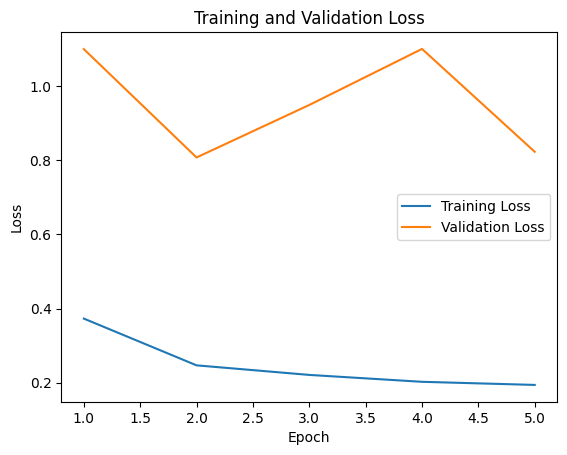

In [421]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Define model, dataset, and dataloaders
model = MLPBinaryClassifier()
train_dataset = MLPDataset(us_X_train, us_y_train)
val_dataset = MLPDataset(us_X_test, us_y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define loss function and optimizer
num_positives = us_y_train.sum()
num_negatives = len(us_y_train) - num_positives
weight2 = num_negatives / num_positives / 6
print(weight2)
class_weights = torch.tensor([1, weight2])  # Example class weights
criterion = nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training settings
num_epochs = 100
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        weights = class_weights[labels.long()]  # Apply class weights
        loss = (loss * weights).mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            weights = class_weights[labels.long()]  # Apply class weights
            loss = (loss * weights).mean()

            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset the counter if validation improves
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
            break

# Plot training and validation losses
import matplotlib.pyplot as plt
epochs_x = range(1, len(train_losses) + 1)
plt.plot(epochs_x, train_losses, label="Training Loss")
plt.plot(epochs_x, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

18.22134178552562
Epoch 1/100, Train Loss: 0.5382, Validation Loss: 0.3369
Epoch 2/100, Train Loss: 0.3702, Validation Loss: 0.3260
Epoch 3/100, Train Loss: 0.3264, Validation Loss: 0.3964
No improvement in validation loss for 1 epoch(s).
Epoch 4/100, Train Loss: 0.3058, Validation Loss: 0.2841
Epoch 5/100, Train Loss: 0.2893, Validation Loss: 0.3400
No improvement in validation loss for 1 epoch(s).
Epoch 6/100, Train Loss: 0.2780, Validation Loss: 0.3560
No improvement in validation loss for 2 epoch(s).
Epoch 7/100, Train Loss: 0.2653, Validation Loss: 0.2793
Epoch 8/100, Train Loss: 0.2548, Validation Loss: 0.3276
No improvement in validation loss for 1 epoch(s).
Epoch 9/100, Train Loss: 0.2479, Validation Loss: 0.3280
No improvement in validation loss for 2 epoch(s).
Epoch 10/100, Train Loss: 0.2396, Validation Loss: 0.2894
No improvement in validation loss for 3 epoch(s).
Epoch 11/100, Train Loss: 0.2331, Validation Loss: 0.2719
Epoch 12/100, Train Loss: 0.2283, Validation Loss: 0.

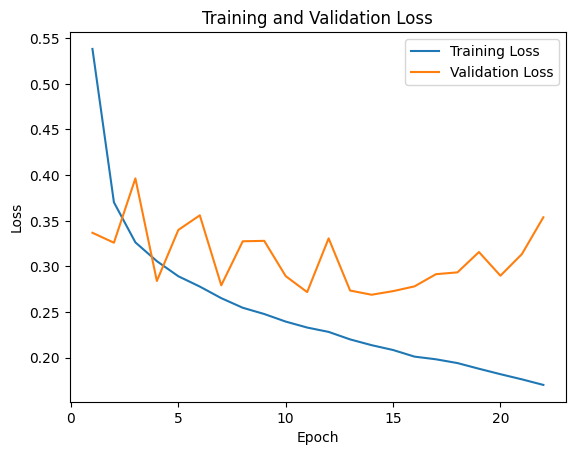

In [626]:
# Use this one
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Define weight initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Xavier initialization
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Define model, dataset, and dataloaders
model = MLPBinaryClassifier()
model.apply(init_weights)  
train_dataset = MLPDataset(us_X_train, us_y_train)
val_dataset = MLPDataset(us_X_test, us_y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define loss function and optimizer
num_positives = us_y_train.sum()
num_negatives = len(us_y_train) - num_positives
weight2 = num_negatives / num_positives / 3
print(weight2)
class_weights = torch.tensor([1, weight2])  # Example class weights
criterion = nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

# Training settings
num_epochs = 100
patience = 8 # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Store best model
best_model_wts = copy.deepcopy(model.state_dict())

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        weights = class_weights[labels.long()]  # Apply class weights
        loss = (loss * weights).mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            weights = class_weights[labels.long()]  # Apply class weights
            loss = (loss * weights).mean()

            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping and saving best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset the counter if validation improves
        best_model_wts = copy.deepcopy(model.state_dict())  # Save best model
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
            break

# Load the best model after training
model.load_state_dict(best_model_wts)
print("Loaded best model with lowest validation loss.")

# Plot training and validation losses
import matplotlib.pyplot as plt
epochs_x = range(1, len(train_losses) + 1)
plt.plot(epochs_x, train_losses, label="Training Loss")
plt.plot(epochs_x, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


In [ ]:
torch.save(model.state_dict(), "mn_pit_lake_clf.pth")

#### Evaluation

In [378]:
# Test set evaluation with masking
model.eval()
criterion = nn.BCELoss(reduction='mean') 
test_dataset = MLPDataset(us_X_test, us_y_test)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, masks, labels in test_loader:
    inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs, masks).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)

        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f"F1 score on test set: {f1:.4f}")

ValueError: not enough values to unpack (expected 3, got 2)

In [627]:
# Test set evaluation
model.eval()
criterion = nn.BCELoss(reduction='mean') 
test_dataset = MLPDataset(us_X_test, us_y_test)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)

        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
all_predicted_outputs = np.array(all_predicted_outputs)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')
accuracy = accuracy_score(all_ground_truths, all_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(all_ground_truths)}')
print(f'True positives: {all_ground_truths.sum()}')
print(f'Predicted positives: {all_predictions.sum()}')

Precision on test set: 0.1651
Recall on test set: 0.6636
Accuracy on test set: 0.9575
F1 score on test set: 0.2644
Total chips: 9288
True positives: 107.0
Predicted positives: 430.0


In [ ]:
# Test set evaluation
model.eval()
criterion = nn.BCELoss(reduction='mean') 
test_dataset = MLPDataset(ont_X_train, ont_y_train)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)

        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
all_predicted_outputs = np.array(all_predicted_outputs)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')
accuracy = accuracy_score(all_ground_truths, all_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(all_ground_truths)}')
print(f'True positives: {all_ground_truths.sum()}')
print(f'Predicted positives: {all_predictions.sum()}')

KeyboardInterrupt: 

In [628]:
# Nondry

#az_X_train, az_y_train, az_train_idx, dataAZmarked = PrepClfTrainTest(dataAZ, az_qa_nondrypits)
#nv_X_train, nv_y_train, nv_train_idx, dataNVmarked = PrepClfTrainTest(dataNV, nv_qa_nondrypits)

#ga_X_train, ga_y_train, ga_train_idx, dataGAmarked = PrepClfTrainTest(dataGA, ga_qa_nondrypits)

#in_X_train, in_y_train, in_train_idx, dataINmarked = PrepClfTrainTest(dataIN, in_qa_nondrypits)

#ilkymo_X_train, ilkymo_y_train, ilkymo_train_idx, dataILKYMOmarked = PrepClfTrainTest(dataILKYMO, il_ky_mo_qa_nondrypits)

mn_X_train, mn_y_train, mn_train_idx, dataMNmarked = PrepClfTrainTest(dataMN, mn_qa_nondrypits)

#mtwy_X_train, mtwy_y_train, mtwy_train_idx, dataMTWYmarked = PrepClfTrainTest(dataMTWY, mt_wy_qa_nondrypits)

#tx_X_train, tx_y_train, tx_train_idx, dataTXmarked = PrepClfTrainTest(dataTX, tx_qa_nondrypits)

#us_X_test = np.vstack([ga_X_train])
#us_y_test = np.concatenate([ga_y_train], axis = 0)

Positive samples: 101
Total samples: 9288
(9288, 1024)
(9288,)


In [629]:
# Test set evaluation
model.eval()
criterion = nn.BCELoss(reduction='mean') 
test_dataset = MLPDataset(mn_X_train, mn_y_train)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)

        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
all_predicted_outputs = np.array(all_predicted_outputs)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')
accuracy = accuracy_score(all_ground_truths, all_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(all_ground_truths)}')
print(f'True positives: {all_ground_truths.sum()}')
print(f'Predicted positives: {all_predictions.sum()}')

Precision on test set: 0.1535
Recall on test set: 0.6535
Accuracy on test set: 0.9570
F1 score on test set: 0.2486
Total chips: 9288
True positives: 101.0
Predicted positives: 430.0


In [ ]:
nm_predicted_outputs = all_predicted_outputs 
nm_ground_truths = all_ground_truths
nm_preds = all_predictions

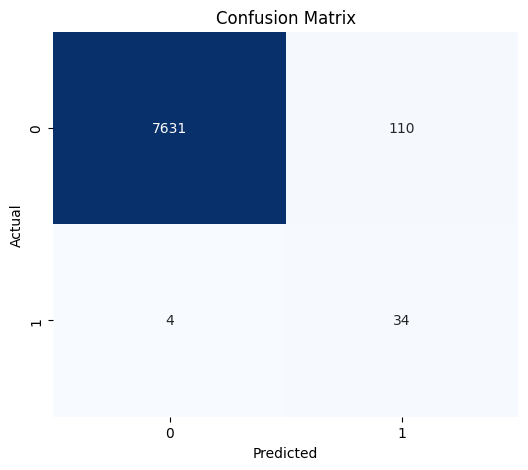

tpr: 0.9473684210526315
threshold: 0.06375260651111603


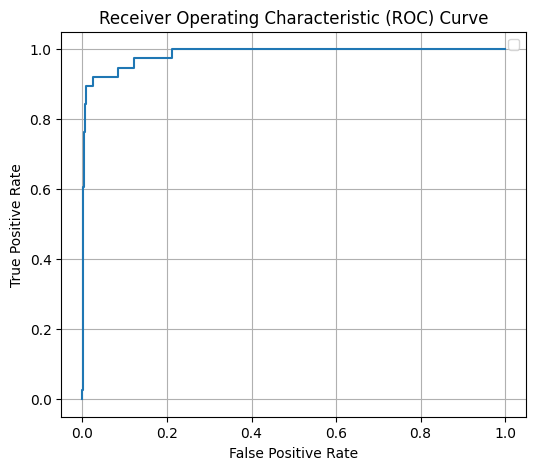

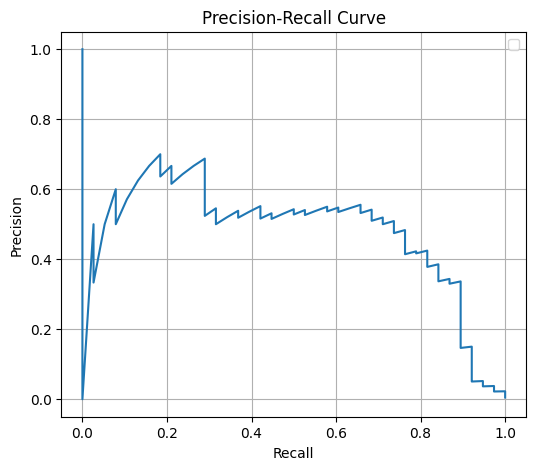

recall: 0.8947368421052632
threshold: 0.4228091537952423


In [550]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

import seaborn as sns

fpr, tpr, thresholds = sklearn.metrics.roc_curve(all_ground_truths, all_predicted_outputs)

cm = sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

# Plot 1: Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
#plt.savefig('data/us_results/ilkymo_cm.png')
plt.show()


# Plot 2: ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()

fpr_max = 0.1
print(f'tpr: {tpr[len(fpr[fpr < fpr_max])-1]}')
print(f'threshold: {thresholds[len(fpr[fpr < fpr_max])-1]}')
#plt.savefig('data/us_results/ilkymo_roc.png')


# Plot 3: Precision-Recall Curve
precision, recall, pr_thresholds = sklearn.metrics.precision_recall_curve(all_ground_truths, all_predicted_outputs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
#plt.savefig('data/us_results/ilkymo_pr.png')
plt.show()

precision_max = 0.20
print(f'recall: {recall[len(precision[precision < precision_max])-1]}')
print(f'threshold: {pr_thresholds[len(precision[precision < precision_max])-1]}')

In [99]:
# Visually inspect
def CreateShapefile(gdf, idx, predictions, filename):
    #filtered_gdf = gdf[idx]
    predictions_gdf = gpd.GeoDataFrame(predictions, geometry = gdf.geometry, columns = ['mine'], crs = '4326')
    print(predictions_gdf)
    file_name = f'data/{filename}.shp'
    predictions_gdf.to_file(file_name)

    return

In [100]:
# Export to shapefile to inspect results
CreateShapefile(dataNMmarked, nm_train_idx, all_predictions, '/us_results/nm_preds_04')

       mine                                           geometry
0       1.0  POLYGON ((-103.7791 32.56872, -103.79027 32.59...
1       0.0  POLYGON ((-103.80801 32.56872, -103.81918 32.5...
2       0.0  POLYGON ((-103.77455 32.50342, -103.78569 32.5...
3       1.0  POLYGON ((-103.76342 32.48165, -103.77455 32.5...
4       1.0  POLYGON ((-106.88282 35.97995, -106.89596 36.0...
...     ...                                                ...
48004   0.0  POLYGON ((-109.01481 31.3754, -109.02599 31.39...
48005   0.0  POLYGON ((-108.96374 31.33216, -108.9749 31.35...
48006   0.0  POLYGON ((-109.00364 31.35378, -109.01481 31.3...
48007   0.0  POLYGON ((-108.99247 31.33216, -109.00364 31.3...
48008   0.0  POLYGON ((-109.02121 31.33216, -109.03237 31.3...

[48009 rows x 2 columns]


In [496]:
def TangIntersection(datamarked, X_train, y_train,  Tang_poly):
    # Get intersecting test
    tang_index = gpd.sjoin(datamarked, mine_poly, how = 'inner', predicate = 'intersects').drop_duplicates('geometry').index.to_list()
    Tangdata = datamarked.reset_index(drop=True).loc[tang_index]
    # Filter list
    tang_X_test = X_train[tang_index]
    tang_y_test = y_train[tang_index]
    print(len(tang_y_test))
    print(tang_y_test.sum())

    return tang_X_test, tang_y_test, Tangdata

In [630]:
# Get Tang polygons intersection 
# ONLY WORKS WITH HELD OUT REGIONS

tang_X_test, tang_y_test, TangMNdata = TangIntersection(dataMNmarked, mn_X_train, mn_y_train, mine_poly)

195
85


In [387]:
# Get Tang polygons intersection 
# ONLY WORKS WITH HELD OUT REGIONS

tang_X_test, tang_y_test, TangNMdata = TangIntersection(dataNMmarked, nm_X_train, nm_y_train, mine_poly)

236
39


In [201]:
TangIntersection(dataAZmarked, az_X_train, az_y_train, mine_poly)
TangIntersection(dataNVmarked, nv_X_train, nv_y_train, mine_poly)
TangIntersection(dataGAmarked, ga_X_train, ga_y_train, mine_poly)
TangIntersection(dataINmarked, in_X_train, in_y_train, mine_poly)
TangIntersection(dataILKYMOmarked, ilkymo_X_train, ilkymo_y_train, mine_poly)
TangIntersection(dataMNmarked, mn_X_train, mn_y_train, mine_poly)
TangIntersection(dataMTWYmarked, mtwy_X_train, mtwy_y_train, mine_poly)
TangIntersection(dataTXmarked, tx_X_train, tx_y_train, mine_poly)


202
61
227
39
212
146
198
82
318
117
195
110
430
86
216
66


(array([[-0.01345485, -0.26811844,  0.29243714, ..., -0.0222764 ,
         -0.00085851,  0.15169452],
        [ 0.07935756, -0.24371013,  0.25638047, ..., -0.03260776,
          0.01025596,  0.14083578],
        [ 0.00294834, -0.26972085,  0.14075567, ..., -0.06709002,
          0.03035083,  0.11829881],
        ...,
        [-0.03306611, -0.29491985,  0.24400125, ..., -0.05967374,
          0.05283879,  0.09783327],
        [-0.06426404, -0.34450692,  0.3635442 , ..., -0.04757246,
          0.03398785,  0.05404086],
        [-0.06846737, -0.31697667,  0.38864446, ..., -0.06309792,
          0.02810209,  0.0890198 ]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

In [619]:
# Tang set evaluation
model.eval()
criterion = nn.BCELoss(reduction='mean') 
test_dataset = MLPDataset(tang_X_test, tang_y_test)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)

        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
all_predicted_outputs = np.array(all_predicted_outputs)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')
accuracy = accuracy_score(all_ground_truths, all_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(all_ground_truths)}')
print(f'True positives: {all_ground_truths.sum()}')
print(f'Predicted positives: {all_predictions.sum()}')

Precision on test set: 0.4148
Recall on test set: 0.5333
Accuracy on test set: 0.5975
F1 score on test set: 0.4667
Total chips: 318
True positives: 105.0
Predicted positives: 135.0


In [55]:
tx_predicted_outputs = all_predicted_outputs 
tx_ground_truths = all_ground_truths

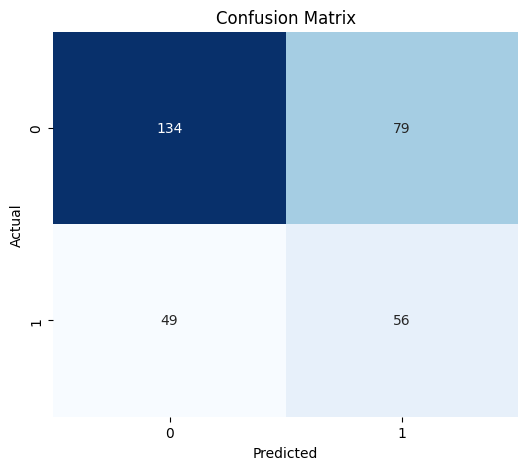

tpr: 0.22857142857142856
threshold: 0.8898811340332031


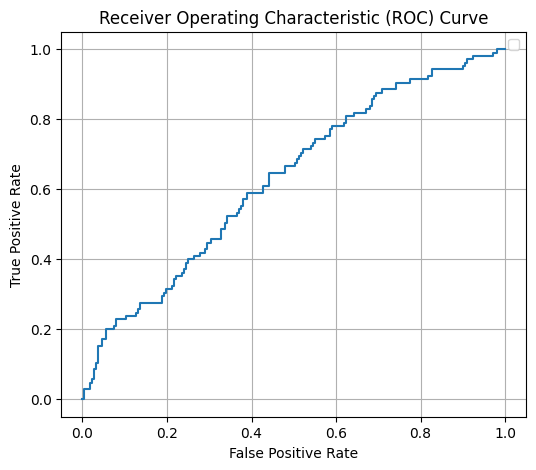

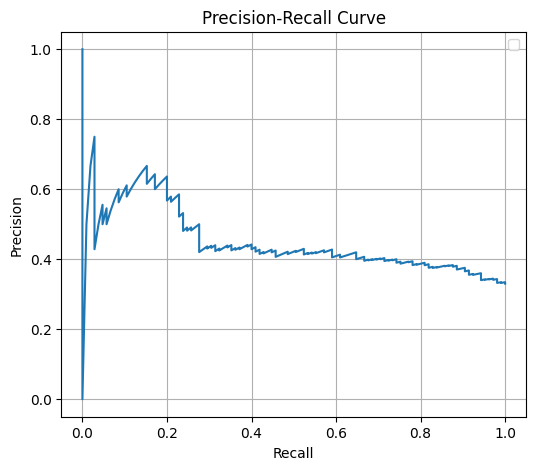

recall: 1.0
threshold: 0.00048545951722189784


In [620]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

import seaborn as sns

fpr, tpr, thresholds = sklearn.metrics.roc_curve(all_ground_truths, all_predicted_outputs)

cm = sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

# Plot 1: Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('data/us_results/ilkymo_cm_tang.png')
plt.show()


# Plot 2: ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()

fpr_max = 0.1
print(f'tpr: {tpr[len(fpr[fpr < fpr_max])-1]}')
print(f'threshold: {thresholds[len(fpr[fpr < fpr_max])-1]}')
plt.savefig('data/us_results/ilkymo_roc_tang.png')


# Plot 3: Precision-Recall Curve
precision, recall, pr_thresholds = sklearn.metrics.precision_recall_curve(all_ground_truths, all_predicted_outputs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.savefig('data/us_results/ilkymo_pr_tang.png')
plt.show()

precision_max = 0.15
print(f'recall: {recall[len(precision[precision < precision_max])-1]}')
print(f'threshold: {pr_thresholds[len(precision[precision < precision_max])-1]}')

#### Plotting results

,Region,Precision,Recall,F1
Region,,,,
NM Full,NM Full,0.0285,0.4468,0.0535
NM Tang,NM Tang,0.3500,0.5385,0.4242


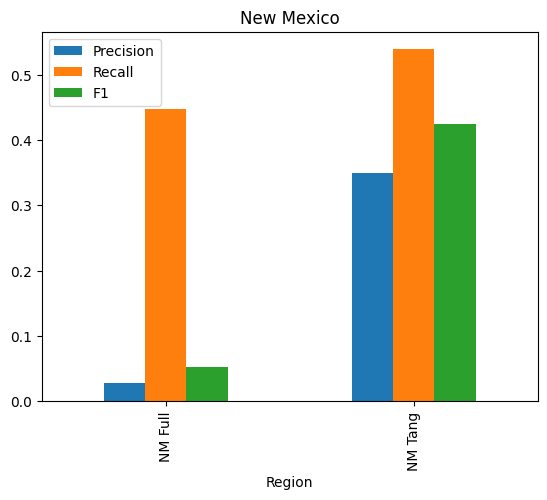

In [135]:
nm_results = pd.DataFrame({'Region': ['NM Tang', 'NM Full'], 'Precision':[0.35, 0.0285], 'Recall':[ 0.5385, 0.4468], 'F1': [0.4242, 0.0535]})
nm_results = nm_results.sort_values(by = 'Recall')
nm_results.index = nm_results['Region']

nm_results.plot(kind='bar')
plt.title('New Mexico')

nm_results


,Region,Precision,Recall,F1
Region,,,,
Ontario Full,Ontario Full,0.0162,0.5196,0.0314
Ontario Tang,Ontario Tang,0.4561,0.5474,0.4976


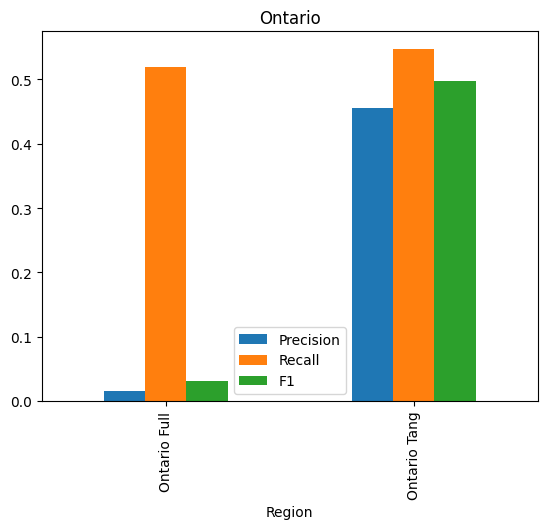

In [137]:
ont_results = pd.DataFrame({'Region': ['Ontario Tang', 'Ontario Full'], 'Precision':[0.4561, 0.0162], 'Recall':[0.5474, 0.5196], 'F1': [ 0.4976, 0.0314]})
ont_results = ont_results.sort_values(by = 'Recall')
ont_results.index = ont_results['Region']

ont_results.plot(kind='bar')
plt.title('Ontario')

ont_results


In [ ]:
print((mt_wy_qa_pits['category'] == 'd').sum())
print((nv_qa_pits['category'] == 'd').sum())
print((ilkymo_qa_pits['category'] == 'd').sum())
print((tx_qa_pits['category'] == 'd').sum())
print((in_qa_pits['category'] == 'd').sum())
print((mn_qa_pits['category'] == 'd').sum())
print((ga_qa_pits['category'] == 'd').sum())
print((az_qa_pits['category'] == 'd').sum())

0
0
0
0
0
0
0
0


In [233]:
results_table = pd.read_csv('data/AquarryReportingResults_summary.csv')
results_table = results_table.drop(columns = 'Accuracy')
area_results = results_table
results_table = results_table.sort_values(by = 'Recall')

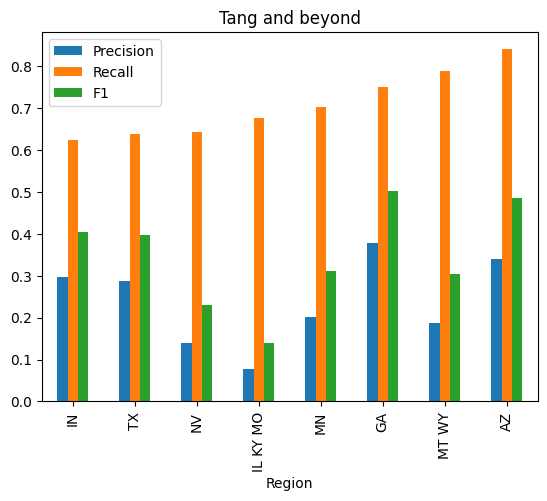

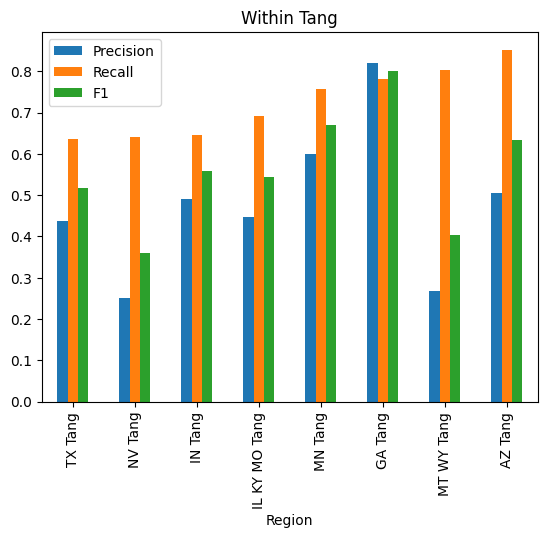

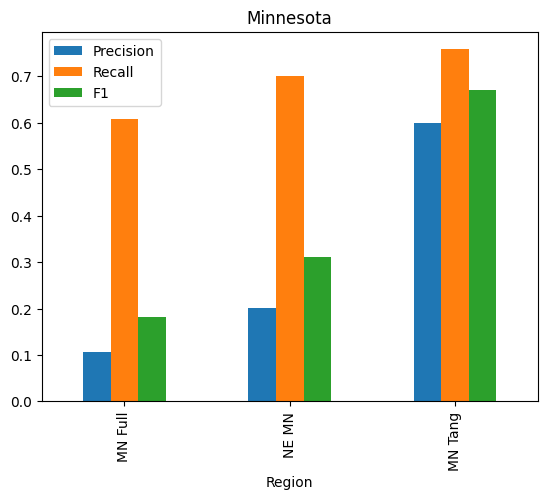

In [228]:
regions = ['AZ', 'NV', 'GA', 'IL KY MO', 'IN', 'MN', 'MT WY', 'TX']
tang_regions = ['AZ Tang', 'NV Tang', 'GA Tang', 'IL KY MO Tang', 'IN Tang', 'MN Tang', 'MT WY Tang', 'TX Tang']
region_results = results_table[results_table['Region'].isin(regions)]
region_results.index = region_results['Region']
tang_results = results_table[results_table['Region'].isin(tang_regions)]
tang_results.index = tang_results['Region']
mn_results = results_table[results_table['Region'].isin(['MN Tang', 'MN', 'MN Full'])]
mn_results.loc[mn_results['Region'] == 'MN','Region'] = 'NE MN'
mn_results.index = mn_results['Region']


region_results.plot(kind='bar')
plt.title('Tang and beyond')

tang_results.plot(kind='bar')
plt.title('Within Tang')

mn_results.plot(kind='bar')

plt.title('Minnesota')

plt.show()

In [234]:
tang_areas = [202,227,212,318,198,195,430,216]
areas = [7779, 2533, 1933, 14395, 2095, 9288, 3985, 2661]
totalchips = sum(tang_areas)
area_results = area_results[area_results['Region'].isin(tang_regions)]
area_results['area_pct'] = [x / totalchips for x in tang_areas]
area_results.loc[area_results['Region'] == 'AZ', 'area_pct']

weighted_precision = (area_results['Precision']*area_results['area_pct']).sum()
print(weighted_precision)
weighted_recall = (area_results['Recall']*area_results['area_pct']).sum()
print(weighted_recall)


0.44995975975975977
0.731561961961962


(array([38., 33., 18., 32., 24., 34., 32., 26., 29., 42.]),
 array([0.50181729, 0.54882669, 0.59583604, 0.64284545, 0.6898548 ,
        0.73686421, 0.78387362, 0.83088297, 0.87789237, 0.92490172,
        0.97191113]),
 <BarContainer object of 10 artists>)

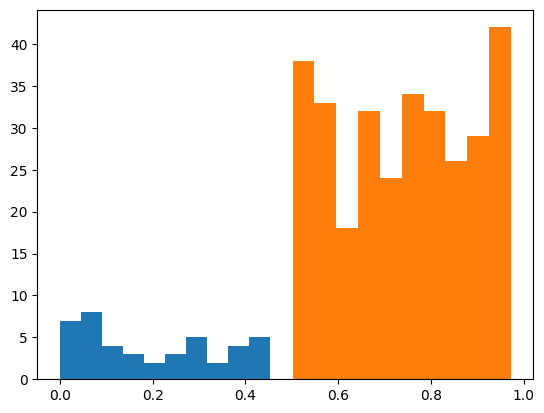

In [63]:
# Inspect false negatives
positives = all_predicted_outputs[all_ground_truths == 1]
plt.hist(positives[positives <= 0.5])

# Inspect false positives
negatives = all_predicted_outputs[all_ground_truths == 0]
plt.hist(negatives[negatives > 0.5])


In [649]:
# Train set evaluation
model.eval()
criterion = nn.BCELoss(reduction='mean') 
train_eval_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in train_eval_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)
        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
prediction_losses = np.array(prediction_losses)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')

print(f"Precision on train set: {precision:.4f}")
print(f"Recall on train set: {recall:.4f}")
print(f"F1 score on train set: {f1:.4f}")

Precision on train set: 0.1997
Recall on train set: 0.9305
F1 score on train set: 0.3288


In [144]:
# Train set evaluation with masking
model.eval()
criterion = nn.BCELoss(reduction='mean') 
train_eval_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, masks, labels in train_eval_loader:
    inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs, masks).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)
        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
prediction_losses = np.array(prediction_losses)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')

print(f"Precision on train set: {precision:.4f}")
print(f"Recall on train set: {recall:.4f}")
print(f"F1 score on train set: {f1:.4f}")

Precision on train set: 0.4612
Recall on train set: 0.8788
F1 score on train set: 0.6049


In [126]:
# For training predictions, find negatives that are high loss
negatives_idx = []
high_loss_negs_idx = []
for i in range(len(all_predictions)):
    if all_predictions[i] == 0:
        negatives_idx.append(i)

for i in range(len(negatives_idx)):
    if prediction_losses[negatives_idx[i]] > 1.2:
        high_loss_negs_idx.append(negatives_idx[i])

# Drop high_loss_negs_idx from us_X_train and us_y_train
print(len(us_X_train))
us_X_train = np.delete(us_X_train, high_loss_negs_idx, axis = 0)
print(len(us_X_train))

print(len(us_y_train))
us_y_train = np.delete(us_y_train, high_loss_negs_idx, axis = 0)
print(len(us_y_train))


32741
32653
32741
32653


In [650]:
# For training predictions, find positives that are high loss

# high loss positives are where model is certain it's positive but it's negative, bc it was told this was positive
positives_idx = []
high_loss_pos_idx = []
for i in range(len(all_predictions)):
    if all_predictions[i] == 1:
        positives_idx.append(i)

# Remove top 5% losses
for i in range(len(positives_idx)):
    if prediction_losses[positives_idx[i]] > (np.percentile(prediction_losses, 99)):
        high_loss_pos_idx.append(positives_idx[i])

# Drop high_loss_negs_idx from us_X_train and us_y_train
print(len(us_X_train))
us_X_train = np.delete(us_X_train, high_loss_pos_idx, axis = 0)
print(len(us_X_train))

print(len(us_y_train))
us_y_train = np.delete(us_y_train, high_loss_pos_idx, axis = 0)
print(len(us_y_train))

32726
32401
32726
32401


In [ ]:
# Need to define 
nm_predictions = gpd.GeoDataFrame(nm_preds, geometry = dataNMmarked.geometry, columns = ['preds']).set_crs(dataNMmarked.crs)

nm_mining_districts = gpd.GeoDataFrame(geometry = [nm_im_districts.geometry.unary_union, nm_coal_districts.geometry.unary_union,
    nm_metals_districts.geometry.unary_union,nm_U_districts.geometry.unary_union]).set_crs(nm_im_districts.crs) # Don't include Potash
nm_mining_districts = nm_mining_districts.to_crs(nm_predictions.crs)

nm_predictions_mining = gpd.sjoin(nm_predictions, nm_mining_districts, how = 'left', predicate = 'intersects').drop_duplicates('geometry').reset_index(drop = True)
nm_predictions_mining['within_mining_district'] = 0
nm_predictions_mining.loc[~nm_predictions_mining['index_right'].isna(), 'within_mining_district'] = 1

within_district = (nm_predictions_mining[nm_predictions_mining['preds'] == 1]['within_mining_district'].sum()) / len(nm_predictions_mining[nm_predictions_mining['preds'] == 1])
print(f'Percent of NM predictions within a mining district: {within_district*100}')

Percent of NM predictions within a mining district: 42.54742547425474


### NDWI Filtering

In [40]:
# Optimize GDAL settings for cloud optimized reading
def SearchSTAC(aoi, start, end):
    os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
    os.environ["AWS_REQUEST_PAYER"] = "requester"

    STAC_API = "https://earth-search.aws.element84.com/v1"
    COLLECTION = "sentinel-2-l2a"

    # Search the catalogue
    catalog = pystac_client.Client.open(STAC_API)
    search = catalog.search(
        collections=[COLLECTION],
        datetime=f"{start}/{end}",
        intersects=aoi,
        #max_items=,
        query={"eo:cloud_cover": {"lt": 10}},
    )

    all_items = search.get_all_items()

    # Reduce to one per date (there might be some duplicates
    # based on the location)
    items = []
    dates = []
    for item in all_items:
        if item.datetime.date() not in dates:
            items.append(item)
            dates.append(item.datetime.date())

    print(f"Found {len(items)} items")

    return items, dates

# CHANGE TARGET PROJECTION AS NEEDED
# Retrieve the pixel values for the bounding box in the target projection.
def RetrievePixels(items,aoi_bounds):
    dask.config.set({"array.slicing.split_large_chunks": True})
    stack = None

    if len(items) != 0:
        #epsg = items[0].properties["proj:epsg"]
        gsd = 10
        valid_stacks = []
        bounds_gdf = gpd.GeoDataFrame(geometry=[aoi_bounds], crs='EPSG:8857')
        transformed_bbox = bounds_gdf.geometry[0].bounds

    if len(items) > 5:
        rand_idx = random.sample(range(0, len(items)), 5)
        items = [items[id] for id in rand_idx]
        print(f'Reduced items to {len(items)}')

    for item in items:
        try:
            # Attempt to create the stack for the current item
            stack = stackstac.stack(
                [item],  # Process one item at a time
                snap_bounds=True,
                epsg=8857,
                resolution=gsd,
                dtype="float32",
                rescale=False,
                fill_value=np.float32(0),
                assets=["green", "nir"],
                resampling=Resampling.nearest,
                chunksize=512,
                bounds=transformed_bbox
            )
            valid_stacks.append(stack)
        except RuntimeError as e:
            # Log and skip the problematic item
            print(f'Error creating stack for item {item.id}: {e}')
            continue

        if len(valid_stacks) != 0:
            combined_stack = dask.array.concatenate(valid_stacks, axis=0).compute()
            #stack = stack.compute()
        
    return stack

 # Calculate NDWI and create water mask 
def CalculateNDWI(image):
    ndwi = image
    green = image.sel(band="green")
    nir = image.sel(band="nir")

    ndwi = (green - nir) / (green + nir)
    return ndwi

In [104]:
from rasterio import features
from affine import Affine
from shapely.geometry import shape
import rioxarray

def RasterstoPolygons(raster):
    raster_array = raster.values # convert to numpy array
    mask = raster_array.astype(bool)
    
    # Get affine transform correctly from rioxarray
    raster.rio.write_crs('epsg:8857', inplace=True)
    xmin, xmax = raster.x.min().item(), raster.x.max().item()
    ymin, ymax = raster.y.min().item(), raster.y.max().item()

    # Get resolution (assuming uniform spacing)
    xres = abs(raster.x[1] - raster.x[0]).item()
    yres = abs(raster.y[1] - raster.y[0]).item()

    transform = Affine(xres, 0, xmin, 0, -yres, ymax)  # Notice -yres because Y decreases

    if mask.any():
        shapes = features.shapes(raster_array, mask=mask, transform=transform)
        geometries = [shape(geom) for geom, _ in shapes]
    else:
        geometries = []

    return geometries    

from shapely.geometry import MultiPolygon

def NDWIFilter(embs_with_polys):
    # Date range
    start = "2022-06-01"    
    end = "2022-08-31"
    filtered_polys = []

    for i in range(len(embs_with_polys)):
        try:
            #Get NDWI
            aoi_epsg4326 = embs_with_polys['geometry'].to_crs(epsg=4326).iloc[i]
            bounds = embs_with_polys['geometry'].iloc[i]   # Should be in epsg:8857

            ndwiimages, ndwidates = SearchSTAC(aoi_epsg4326, start, end) 

            #try: 
            ndwistack = RetrievePixels(ndwiimages, bounds)
            summer_composite = ndwistack.groupby('band').median(dim = 'time')
            ndwi_summer = CalculateNDWI(summer_composite)

                # Compute mask
            ndwi_threshold = 0.05
            water_mask = xr.where(ndwi_summer > ndwi_threshold, 1, 0)

            print(f'Water mask positive pixels: {water_mask.sum().values}')
            #print(f'Filtered raster shape: {water_mask.shape}')

            # Get polygons for the given raster, and store polygons
            filtered_polys.append(RasterstoPolygons(water_mask))
        except AttributeError:
            filtered_polys.append([])
            print(f'Something went wrong on {i}')
    
    embs_with_polys['pit_lake_polygons'] = filtered_polys
    embs_with_polys["pit_lake_geoms"] = embs_with_polys["pit_lake_polygons"].apply(lambda x: MultiPolygon(x) if x else None)
    embs_with_polys["pit_lake_geoms"] = embs_with_polys["pit_lake_geoms"].apply(lambda x: unary_union([x.buffer(0.0005)]) if x else None)

    return embs_with_polys

In [42]:
# Get positive prediction chips
dataAZpredicted = gpd.GeoDataFrame({'mine_prob': az_predicted_outputs,'ground_truth': az_ground_truths}, geometry = Tangdata.reset_index(drop=True).geometry, crs = '4326')
dataAZpositives = dataAZpredicted[dataAZpredicted['mine_prob'] > 0.5]
dataAZpositives = dataAZpositives.to_crs(epsg = '8857') # Convert back to 8857 for easier chipping
print(f'Check if any geometries are NA: {dataAZpositives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
dataAZpositives_polys = NDWIFilter(dataAZpositives)

# Explode back into individual polygons
dataAZpositives_polys["exploded"] = dataAZpositives_polys['pit_lake_geoms'].apply(lambda x: x.geoms if type(x) == MultiPolygon else x)
dataAZpositives_polys = dataAZpositives_polys.explode("exploded", ignore_index=False)

NameError: name 'az_predicted_outputs' is not defined

In [ ]:
# dissolve into just unique chips
# Create updated prediction column
#dataAZpositives_polys = dataAZpositives_polys.to_crs(epsg=4326)
dataAZpredicted = dataAZpredicted.to_crs(epsg=8857) # Have to convert this one since there are slight differences
dataAZpositives_polys['updated_preds'] = dataAZpositives_polys['exploded'].apply(lambda x: 1 if x is not None else 0)
dataAZpositives_polys_chips = dataAZpositives_polys.drop_duplicates('geometry')

# Merge back into dataAZpredicted
dataAZpredicted_updated = dataAZpredicted.merge(dataAZpositives_polys_chips[['geometry','updated_preds']], on='geometry', how='left')
dataAZpredicted_updated.loc[dataAZpredicted_updated['updated_preds'].isna(), 'updated_preds'] = 0 

az_updated_predictions = np.array(dataAZpredicted_updated['updated_preds'])

precision = precision_score(az_ground_truths, az_updated_predictions, average='binary')
recall = recall_score(az_ground_truths, az_updated_predictions, average='binary')
f1 = f1_score(az_ground_truths, az_updated_predictions, average='binary')
accuracy = accuracy_score(az_ground_truths, az_updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(az_ground_truths)}')
print(f'True positives: {az_ground_truths.sum()}')
print(f'Predicted positives: {az_updated_predictions.sum()}')

Precision on test set: 0.3723
Recall on test set: 0.9211
Accuracy on test set: 0.6931
F1 score on test set: 0.5303
Total chips: 202
True positives: 38.0
Predicted positives: 94.0


In [56]:
# TX
#  Get positive prediction chips
dataTXpredicted = gpd.GeoDataFrame({'mine_prob': tx_predicted_outputs,'ground_truth': tx_ground_truths}, 
                                    geometry = TangTXdata.reset_index(drop=True).geometry, crs = '4326')
dataTXpositives = dataTXpredicted[dataTXpredicted['mine_prob'] > 0.5]
dataTXpositives = dataTXpositives.to_crs(epsg = '8857') # Convert back to 8857 for easier chipping
print(f'Check if any geometries are NA: {dataTXpositives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
dataTXpositives_polys = NDWIFilter(dataTXpositives)

# Explode back into individual polygons
dataTXpositives_polys["exploded"] = dataTXpositives_polys['pit_lake_geoms'].apply(lambda x: x.geoms if type(x) == MultiPolygon else x)
dataTXpositives_polys = dataTXpositives_polys.explode("exploded", ignore_index=False)

# dissolve into just unique chips
# Create updated prediction column
dataTXpredicted = dataTXpredicted.to_crs(epsg=8857) # Have to convert this one since there are slight differences
dataTXpositives_polys['updated_preds'] = dataTXpositives_polys['exploded'].apply(lambda x: 1 if x is not None else 0)
dataTXpositives_polys_chips = dataTXpositives_polys.drop_duplicates('geometry')

# Merge back in
dataTXpredicted_updated = dataTXpredicted.merge(dataTXpositives_polys_chips[['geometry', 'updated_preds']], on='geometry', how='left')
dataTXpredicted_updated.loc[dataTXpredicted_updated['updated_preds'].isna(), 'updated_preds'] = 0 

# Assign old values 
tx_updated_predictions = np.array(dataTXpredicted_updated['updated_preds'])

precision = precision_score(tx_ground_truths, tx_updated_predictions, average='binary')
recall = recall_score(tx_ground_truths, tx_updated_predictions, average='binary')
f1 = f1_score(tx_ground_truths, tx_updated_predictions, average='binary')
accuracy = accuracy_score(tx_ground_truths, tx_updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(tx_ground_truths)}')
print(f'True positives: {tx_ground_truths.sum()}')
print(f'Predicted positives: {tx_updated_predictions.sum()}')

NameError: name 'TangTXdata' is not defined

In [ ]:
dataTXpositives_polys['preds'] = 0
dataTXpositives_polys.loc[dataTXpositives_polys['mine_prob'] > 0.5, 'preds'] = 1
dataTXexport = gpd.GeoDataFrame(dataTXpositives_polys.drop(columns = 'geometry'), geometry = 'exploded', crs = '8857')
dataTXexport.to_file('data/CentralTX_predictions.shp')
#CreateCSV(dataNVexport, 'NorthernNevada_predictions.csv')